In [455]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
import statistics
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.multivariate import manova
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.contingency_tables import StratifiedTable # CMH
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as smf
import scipy.stats as stats
import missingno as msno
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from collections import Counter

# Mesure de l'hétéroscedasticité
import statsmodels.api as sm
import statsmodels.stats.api as sms

import warnings

dataset = pd.read_csv("sets/train.csv")
df = dataset.copy()

pd.set_option("display.float_format", "{:.2f}".format)
warnings.filterwarnings("ignore")

# **Exploratory Data Analysis (EDA)**
## **1. Checklist de base**
## - Basic Exploration :
- ### Variable target :
  - Type : `df[target].dtypes` : int64 (multiclasse)
  - Distribution des classes : 7 classes complétement équilibré
  - Résumé statistique : `df[target].describe()` :
    - count   15120.00
    - mean        4.00
    - std         2.00
    - min         1.00
    - 25%         2.00
    - 50%         4.00
    - 75%         6.00
    - max         7.00


In [456]:
print(df.head(2))

   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5

In [457]:
print(df["Cover_Type"].value_counts())

Cover_Type
5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: count, dtype: int64


In [458]:
print(df["Cover_Type"].describe())

count   15120.00
mean        4.00
std         2.00
min         1.00
25%         2.00
50%         4.00
75%         6.00
max         7.00
Name: Cover_Type, dtype: float64


- ### Lignes et colonnes :
  - Nombre de lignes et de colonnes : `df.shape` : (15120, 56)
  - Données uniques / redondantes : `df.columns.duplicated()` : aucune duplication


In [459]:
print(df.shape)
print(df.columns.duplicated())

(15120, 56)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


- ### Types de variables :
  - Catégorielles : 45
  - Continues : 9
  - Dates / Temps : 0

In [460]:
print(df.columns)
print(df["Hillshade_3pm"].head())

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

- ### Analyse de valeurs manquantes (heatmap) :
  - Proportions par colonnes : 0
  - Méthodes de gestion :     
    - Supression :     
    - Imputation :    


Id                                   0.00
Elevation                            0.00
Aspect                               0.00
Slope                                0.00
Horizontal_Distance_To_Hydrology     0.00
Vertical_Distance_To_Hydrology       0.00
Horizontal_Distance_To_Roadways      0.00
Hillshade_9am                        0.00
Hillshade_Noon                       0.00
Hillshade_3pm                        0.00
Horizontal_Distance_To_Fire_Points   0.00
Wilderness_Area1                     0.00
Wilderness_Area2                     0.00
Wilderness_Area3                     0.00
Wilderness_Area4                     0.00
Soil_Type1                           0.00
Soil_Type2                           0.00
Soil_Type3                           0.00
Soil_Type4                           0.00
Soil_Type5                           0.00
Soil_Type6                           0.00
Soil_Type7                           0.00
Soil_Type8                           0.00
Soil_Type9                        

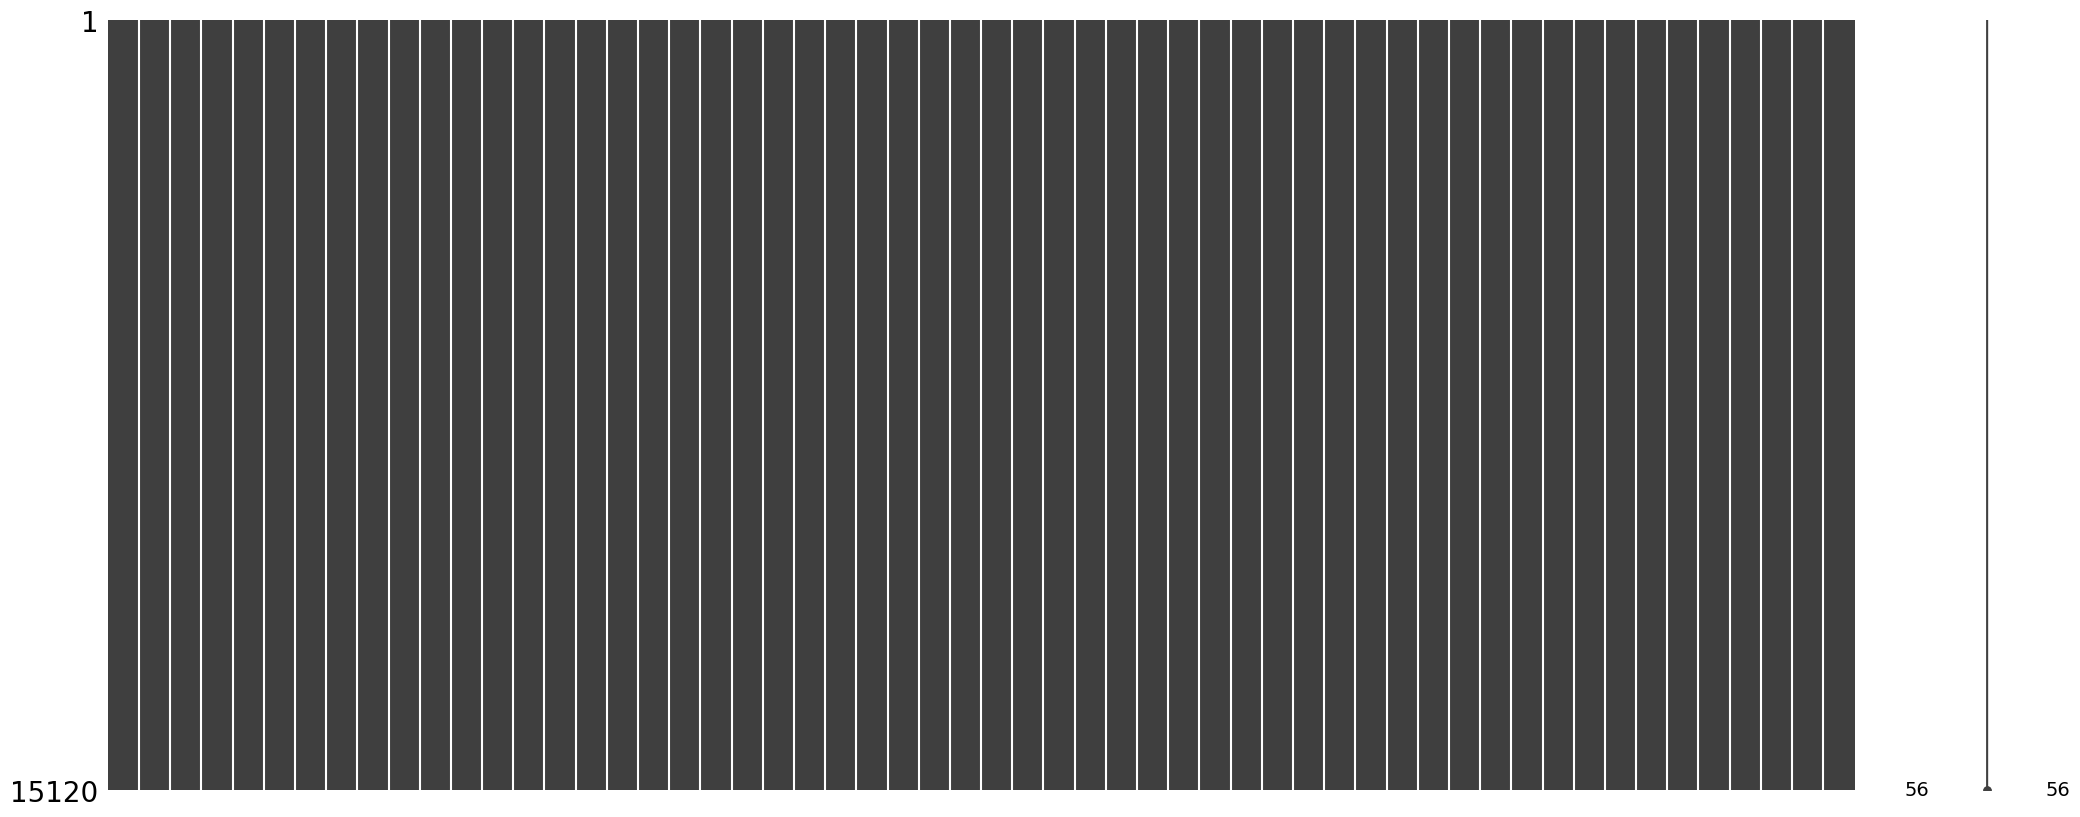

In [461]:
msno.matrix(df)
nan_value = df.isna().sum()/df.shape[0]
print(nan_value)

- ### Analyse des outliers (IQR, Z-score, boxplot) :
  - Proportions par colonnes (IQR) :
    - Slope : 39 : 0.0025793650793650793
    - Horizontal_Distance_To_Hydrology : 285 : 0.018849206349206348
    - Vertical_Distance_To_Hydrology : 213 : 0.014087301587301588
    - Horizontal_Distance_To_Roadways : 155 : 0.0102513227513227
  - Observations : 
    - l'isolation forest ne détecte aucun outliers
    - environ 500 outliers avec le Z-score, cohérent avec l'IQR et le boxplot
  - Méthodes de gestion :
    - Supression : outliers extrème de 'Horizontal_Distance_To_Hydrology'
    - Imputation : possible imputation des légers outliers de 'Horizontal_Distance_To_Hydrology'


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Elevation'),
  Text(1, 0, 'Aspect'),
  Text(2, 0, 'Slope'),
  Text(3, 0, 'Horizontal_Distance_To_Hydrology'),
  Text(4, 0, 'Vertical_Distance_To_Hydrology'),
  Text(5, 0, 'Horizontal_Distance_To_Roadways'),
  Text(6, 0, 'Horizontal_Distance_To_Fire_Points')])

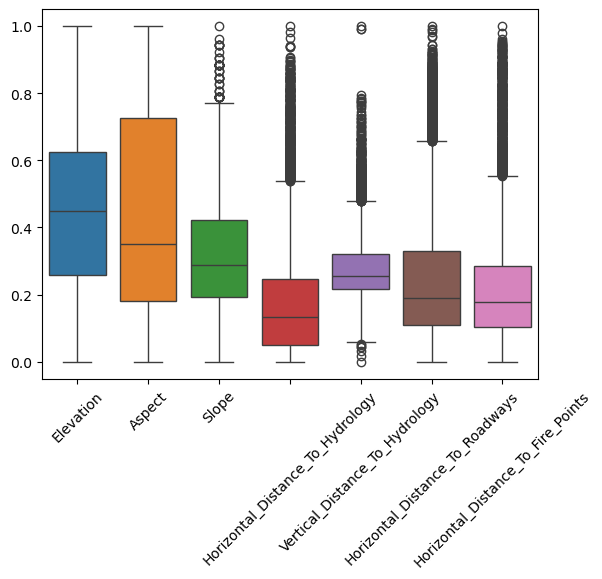

In [462]:
continuous_features = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", 
                       "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]
categorial_features = df.drop(continuous_features, axis=1).columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df[continuous_features]), columns=continuous_features)
sns.boxplot(scaled_df[continuous_features])
plt.xticks(rotation=45)

In [463]:
def outlier_detection(df):
    anomalies = []

    # limite supérieur et inféfieur à 3 écarts-types
    data_std = statistics.stdev(df)
    data_mean = statistics.mean(df)
    anomaly_cut_off = data_std * 3

    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    for outlier in df:
        if outlier < lower_limit or outlier > upper_limit:
            anomalies.append(outlier)
    return anomalies

n_outliers = 0
for col in continuous_features:
    outliers = outlier_detection(df[col])
    print(f"{col} : {len(outliers)} : {len(outliers)/df.shape[0]}")
    n_outliers += len(outliers)

print(f"Nombres d'outliers : {n_outliers} : {n_outliers/df.shape[0]}")

Elevation : 0 : 0.0
Aspect : 0 : 0.0
Slope : 39 : 0.0025793650793650793
Horizontal_Distance_To_Hydrology : 285 : 0.018849206349206348
Vertical_Distance_To_Hydrology : 213 : 0.014087301587301588
Horizontal_Distance_To_Roadways : 155 : 0.01025132275132275
Horizontal_Distance_To_Fire_Points : 331 : 0.021891534391534392
Nombres d'outliers : 1023 : 0.06765873015873015


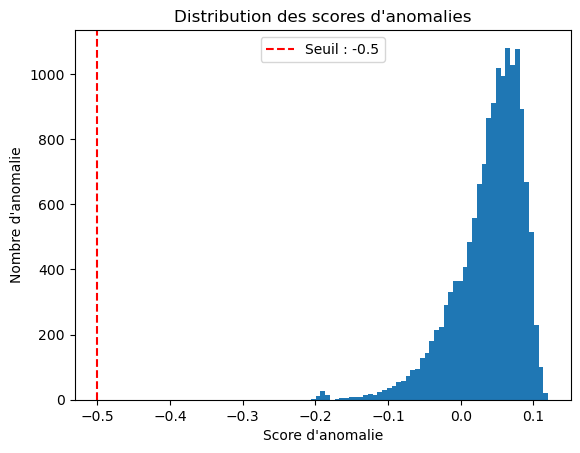

In [464]:
model = IsolationForest(random_state=0, contamination='auto')
model.fit(scaled_df)
outliers_predict = model.predict(scaled_df) == -1
anomaly_score = model.decision_function(scaled_df)

plt.hist(anomaly_score, bins=50)
plt.axvline(x=-0.5, color='red', linestyle='--', label="Seuil : -0.5")
plt.title("Distribution des scores d'anomalies")
plt.xlabel("Score d'anomalie")
plt.ylabel("Nombre d'anomalie")
plt.legend()

In [465]:
z_score = stats.zscore(scaled_df)
outliers = df[(np.abs(z_score) > 3).any(axis=1)]
print("Nombre d'outliers (Z-score > 3) : ", len(outliers))

Nombre d'outliers (Z-score > 3) :  884




---


## - Data Cleaning :    
- ### Renommer les colonnes : `df.rename(function, axis=1, inplace=true)` : `col.replace(a, b)` :  

- ### Supprimer les colonnes inutiles :    

In [466]:
print(df.columns)
df = df.drop("Id", axis=1)

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

- ### Fusionner les colonnes redondantes :    

- ### Convertir les types des colonnes :   

In [467]:
df = df.astype({col : "int16" for col in df.columns})
print(df.memory_usage())

Index                                   132
Elevation                             30240
Aspect                                30240
Slope                                 30240
Horizontal_Distance_To_Hydrology      30240
Vertical_Distance_To_Hydrology        30240
Horizontal_Distance_To_Roadways       30240
Hillshade_9am                         30240
Hillshade_Noon                        30240
Hillshade_3pm                         30240
Horizontal_Distance_To_Fire_Points    30240
Wilderness_Area1                      30240
Wilderness_Area2                      30240
Wilderness_Area3                      30240
Wilderness_Area4                      30240
Soil_Type1                            30240
Soil_Type2                            30240
Soil_Type3                            30240
Soil_Type4                            30240
Soil_Type5                            30240
Soil_Type6                            30240
Soil_Type7                            30240
Soil_Type8                      

- ### Gérer les valeurs manquantes :

- ### Gérer les outliers :

In [468]:
outliers = scaled_df[scaled_df["Vertical_Distance_To_Hydrology"] > 0.9]
print(outliers.index)
df = df.drop(outliers.index)

Index([1803, 1892, 11938], dtype='int64')




---


## **2. Exploration Uni-variable**
- ### Variables Continues :
  - Skewness (>0.5 ou <-0.5) : `(décalé)` :  
    - Horizontal_Distance_To_Hydrology   1.49
    - Vertical_Distance_To_Hydrology     1.46
    - Horizontal_Distance_To_Roadways    1.25
    - Horizontal_Distance_To_Roadways    1.25
    - Slope                              0.52
  - Kurtosis (>5 ou ou <1) : `(forme applatie/pointue)` :
    - Slope                              -0.24
    - Elevation                          -1.08
    - Aspect                             -1.15
  - Variance (cv>1.5 ou <0.1):
    - Elevation                          0.15
  - Normalité (p-value < 0.05) :
    - toutes les variables suivent une distributions anormales
  - Homoscedasticité (Breusch-Pagan >0.05):
    - target catégorielle
  - Observations : 
    - les 'Distance_To_Hydrology' ont une grande proportion de valeurs = 0
    - les 'Distance' possèdent certains outliers au delà de la moustache supérieur (Q3 + 1.5 * IQR)
    - classification impossible avec MNLogit, multicolinéarité ?
    - transformations mathématique et encodage nécessaire pour les problèmes de skewness et kurtosis

In [469]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- Statistiques de base (skew, kurt, var, std, range) : 

In [470]:
skewness = df[continuous_features].skew().sort_values(ascending=False)
kurtosis = df[continuous_features].kurt().sort_values(ascending=False)
standard_deviation = df[continuous_features].std().sort_values(ascending=False)
variance_coefficient = standard_deviation / df[continuous_features].mean().sort_values(ascending=False)
print("kurtosis : ", kurtosis)
print("variance : ", variance_coefficient)
print("standard_deviation : ", standard_deviation)

kurtosis :  Horizontal_Distance_To_Fire_Points    3.39
Horizontal_Distance_To_Hydrology      2.81
Vertical_Distance_To_Hydrology        2.69
Horizontal_Distance_To_Roadways       1.02
Slope                                -0.24
Elevation                            -1.08
Aspect                               -1.15
dtype: float64
variance :  Aspect                               0.70
Elevation                            0.15
Horizontal_Distance_To_Fire_Points   0.73
Horizontal_Distance_To_Hydrology     0.92
Horizontal_Distance_To_Roadways      0.77
Slope                                0.51
Vertical_Distance_To_Hydrology       1.19
dtype: float64
standard_deviation :  Horizontal_Distance_To_Roadways      1325.14
Horizontal_Distance_To_Fire_Points   1099.96
Elevation                             417.71
Horizontal_Distance_To_Hydrology      209.94
Aspect                                110.08
Vertical_Distance_To_Hydrology         60.84
Slope                                   8.45
dtype: float64

- Forme de la distribution (Histogramme, Boxplot, Scatterplot) : 

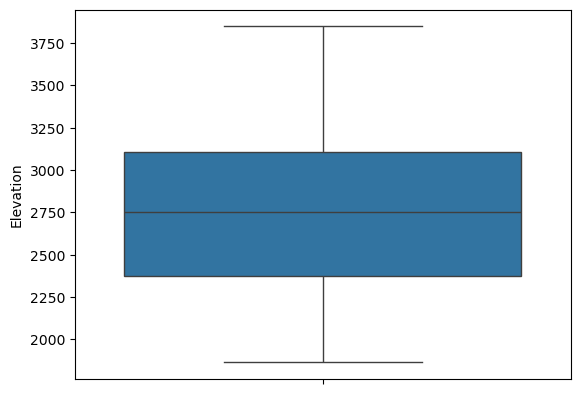

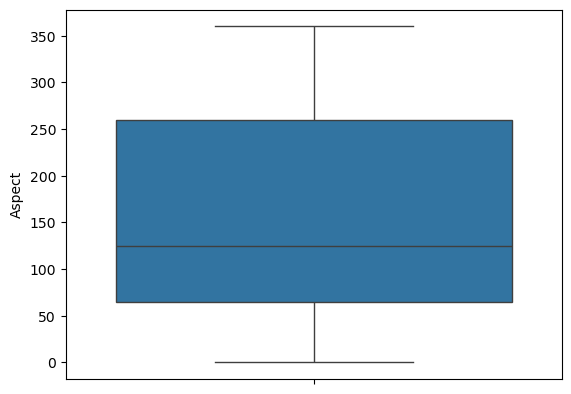

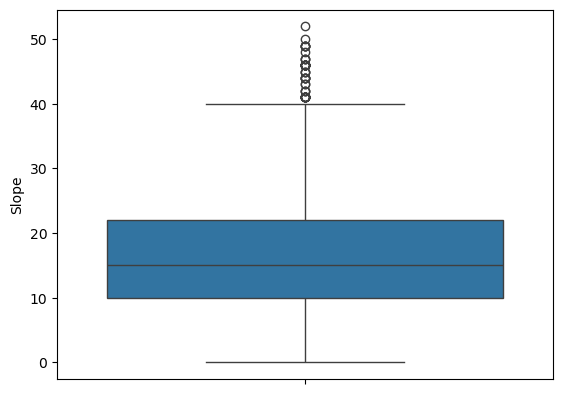

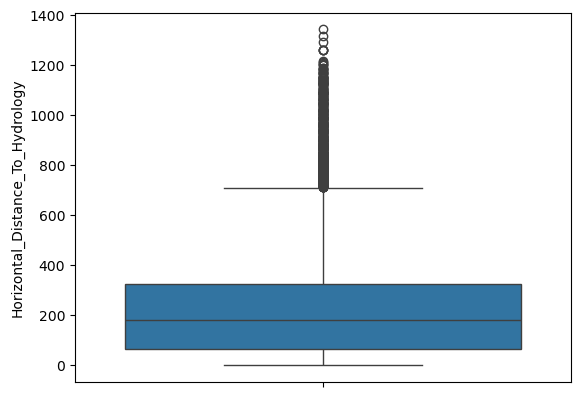

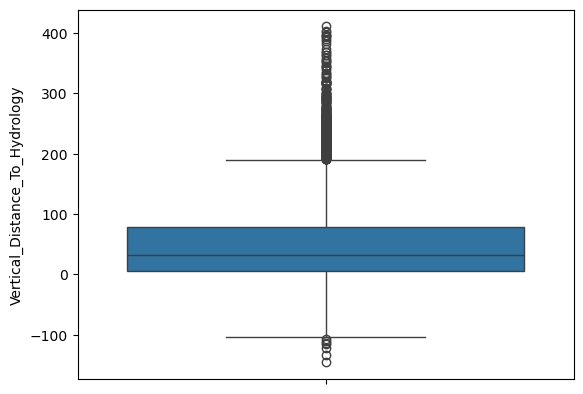

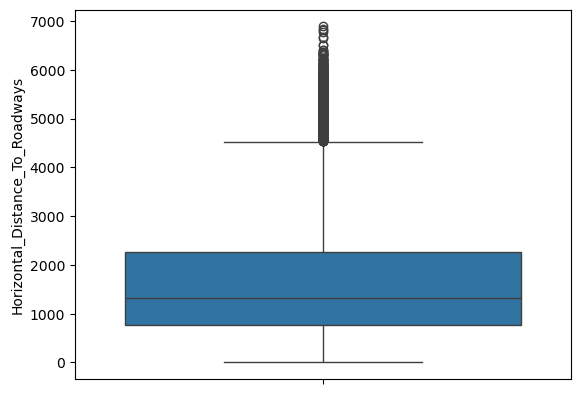

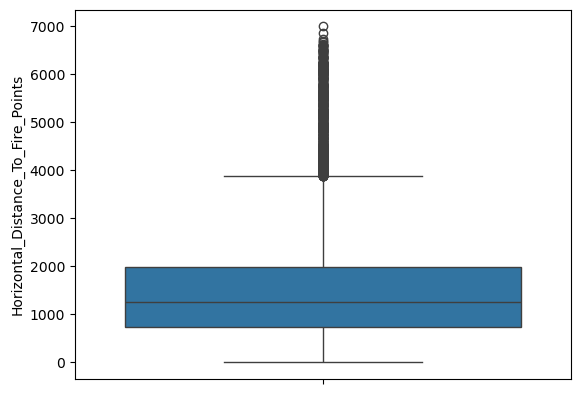

In [471]:
for col in continuous_features:
    plt.figure()
    sns.boxplot(df[col])

In [472]:
print(df[df["Horizontal_Distance_To_Hydrology"] > 650].shape[0])

686


- Normalité (QQPlot, Shapiro-Wilk, Kolmogorov-Smirnov, Lilliefors) : 

In [473]:
for col in continuous_features:
    #plt.figure()
    #stats.probplot(df[col], dist='norm', plot=plt)
    stat, p_value = stats.shapiro(df[col])
    print(f"p_value : {p_value}")

p_value : 5.352454591351092e-50
p_value : 5.009512004627111e-68
p_value : 1.5153756174700025e-46
p_value : 4.729465821803842e-76
p_value : 8.959948007554246e-77
p_value : 1.2871075028045188e-74
p_value : 1.5674878716515788e-76


- Homoscedasticité (Breusch-Pagan, probplot) : 

- ### Variables Catégorielles :
  - Multiclasse : 'Hillshade' et 'Cover_Type'
  - Binaire : 'Wilderness_Area' et 'Soil_Type'
  - Catégories dominantes :
    - Hillshade_9am : augmente progressivement jusqu'à environ 220/255 (pic) puis diminue
    - Hillshade_Noon : similaire à 'Hillshade_9am'
    - Hillshade_3pm : idem mais pic vers 150/255
    - 'Wilderness_Area1' et 'Wilderness_Area2' : classe 0 très dominante
    - 'Wilderness_Area4' : classe 0 dominante (x2)
    - 'Soil_Type' : classe 0 LARGEMENT dominante
  - Statistiques de proabilité : 
    - PMF :
    - CDF :
  - Observations : 
    - 'Soil_Type7' et 15 n'ont qu'une seule classe : inutile
    - les 'Hillshade' pourrait être corrélé, ils ont un pic à des classes différentes, mais le paterne reste le même
    - les 'Soil_Type' devront sûrement tous être supprimé, dû au déséquilibre extrême

In [474]:
categorial_features = df.drop(continuous_features, axis=1).columns
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type'],
      dtype='object')


- Statistiques descriptives (fréquence, mode): 

In [475]:
print(df[categorial_features].nunique())

Hillshade_9am       176
Hillshade_Noon      141
Hillshade_3pm       247
Wilderness_Area1      2
Wilderness_Area2      2
Wilderness_Area3      2
Wilderness_Area4      2
Soil_Type1            2
Soil_Type2            2
Soil_Type3            2
Soil_Type4            2
Soil_Type5            2
Soil_Type6            2
Soil_Type7            1
Soil_Type8            2
Soil_Type9            2
Soil_Type10           2
Soil_Type11           2
Soil_Type12           2
Soil_Type13           2
Soil_Type14           2
Soil_Type15           1
Soil_Type16           2
Soil_Type17           2
Soil_Type18           2
Soil_Type19           2
Soil_Type20           2
Soil_Type21           2
Soil_Type22           2
Soil_Type23           2
Soil_Type24           2
Soil_Type25           2
Soil_Type26           2
Soil_Type27           2
Soil_Type28           2
Soil_Type29           2
Soil_Type30           2
Soil_Type31           2
Soil_Type32           2
Soil_Type33           2
Soil_Type34           2
Soil_Type35     

In [476]:
categorial_features = categorial_features.drop(["Soil_Type7", "Soil_Type15"])

In [477]:
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Distribution des classes (barchat, countplot) : 

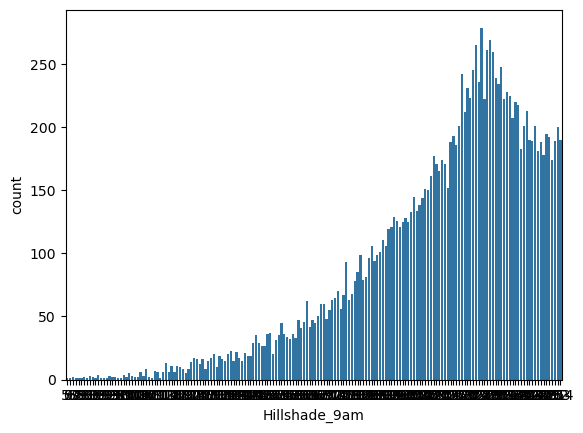

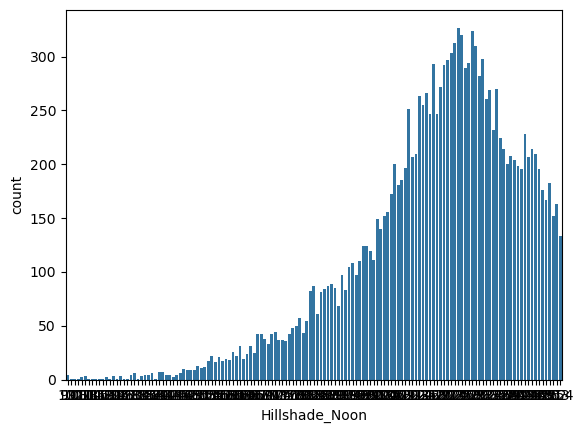

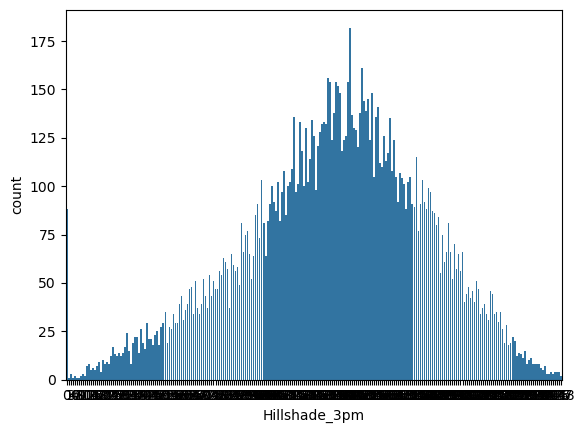

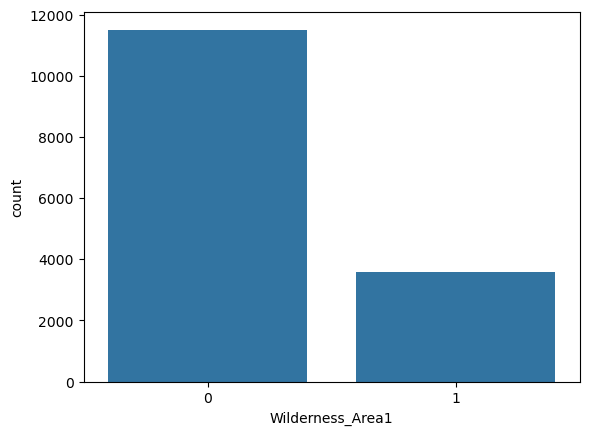

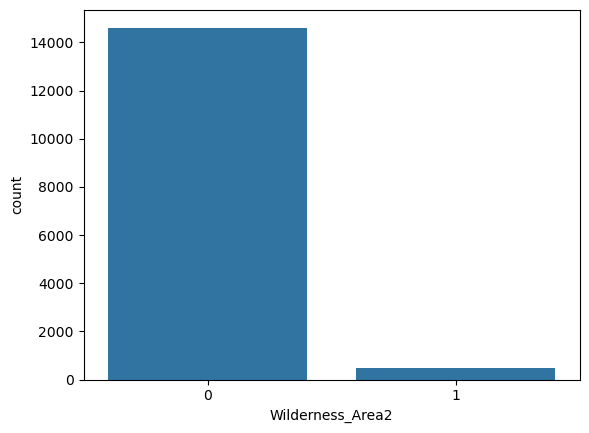

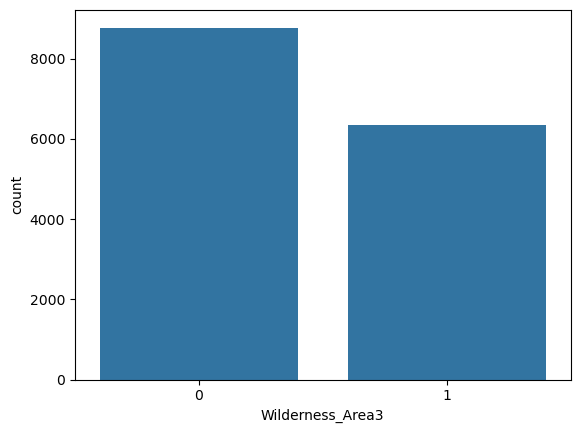

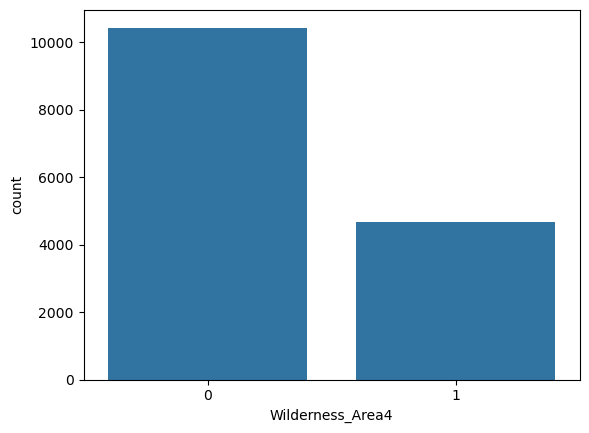

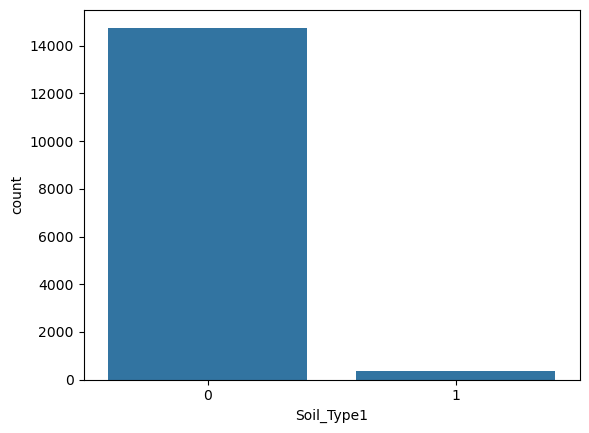

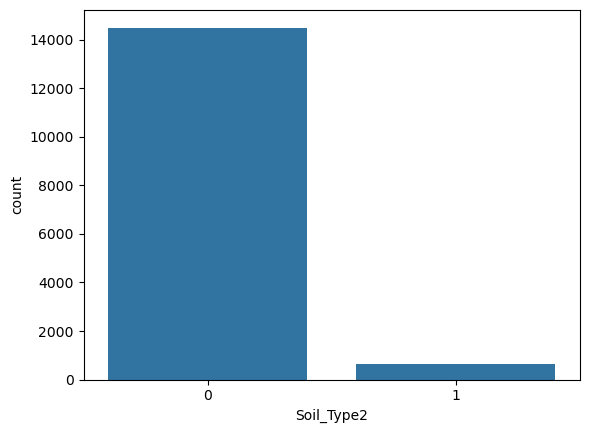

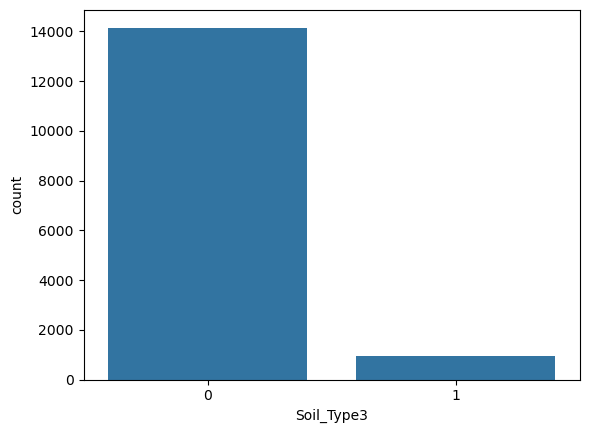

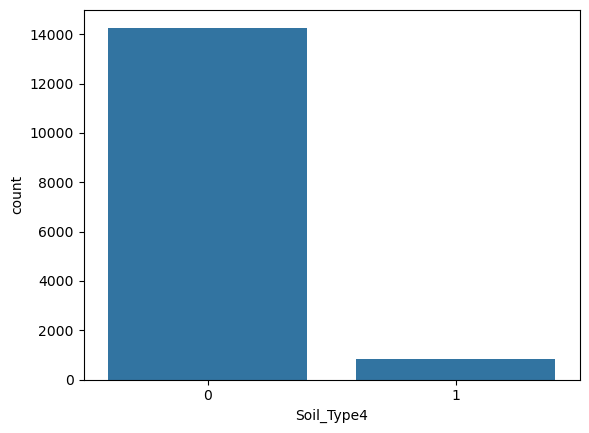

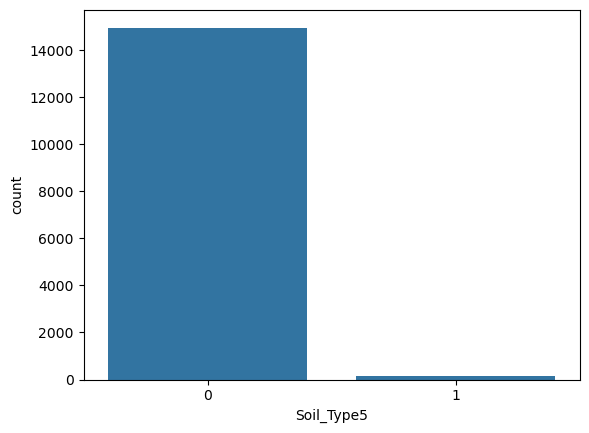

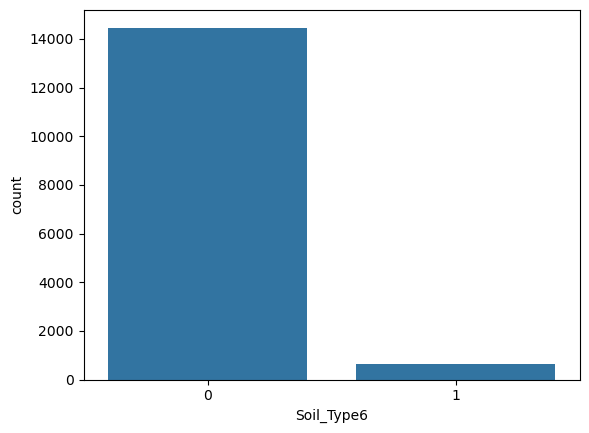

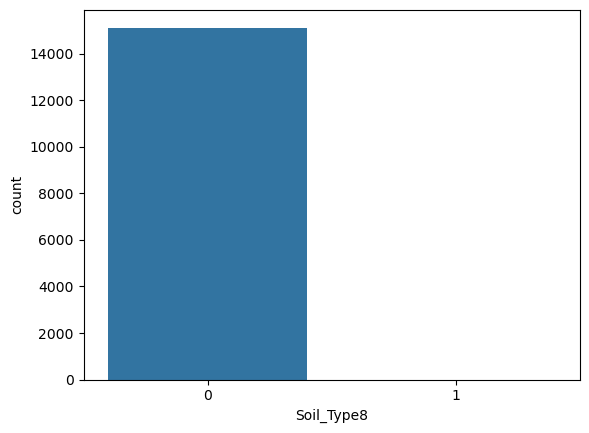

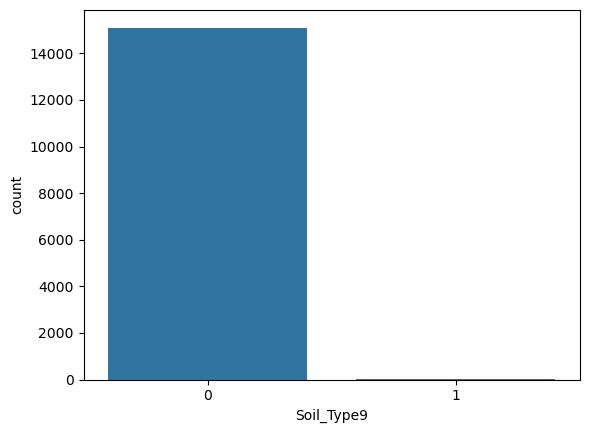

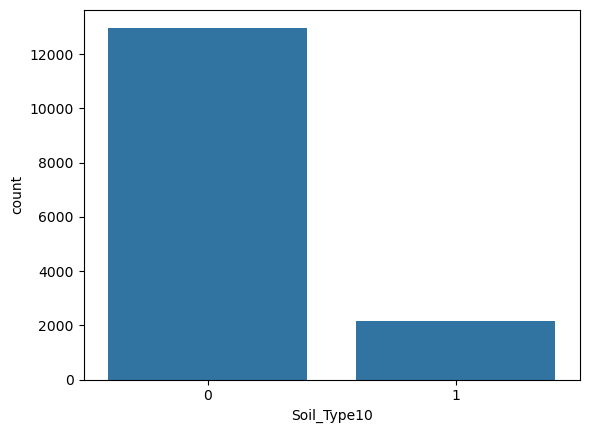

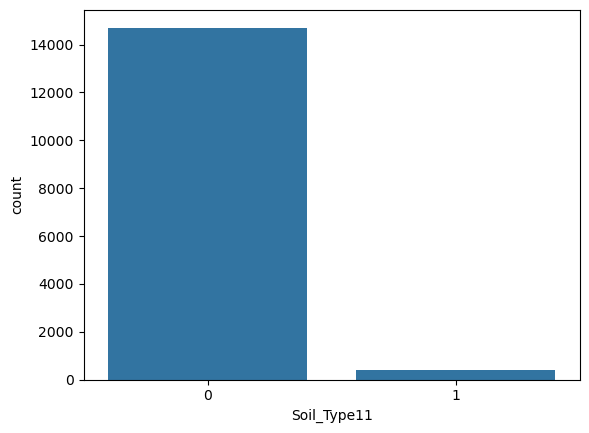

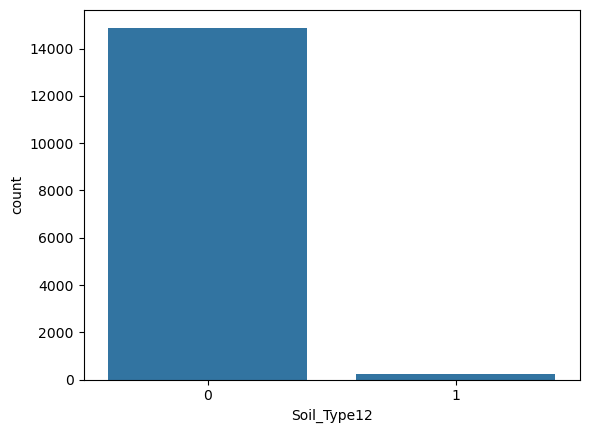

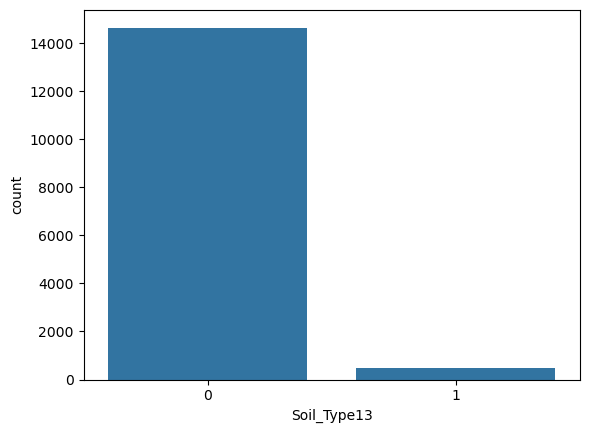

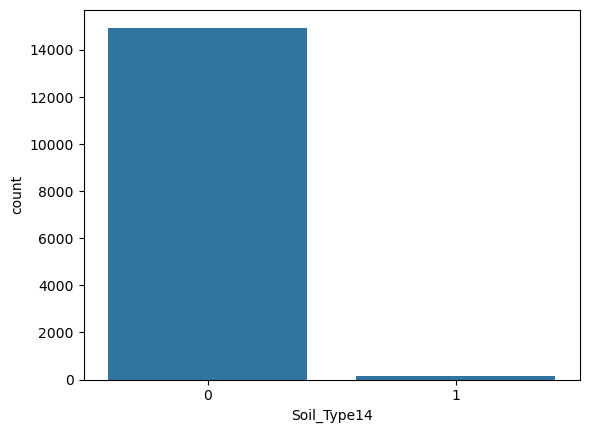

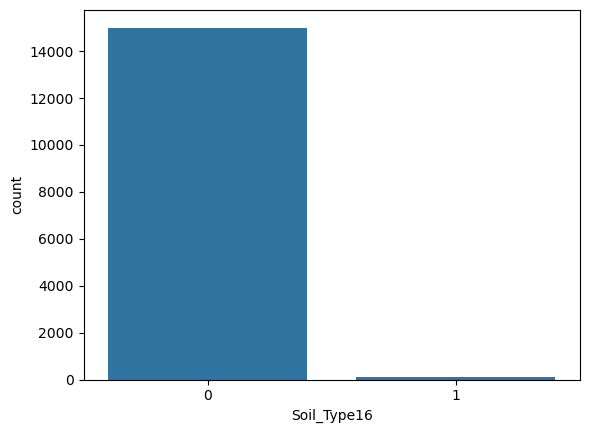

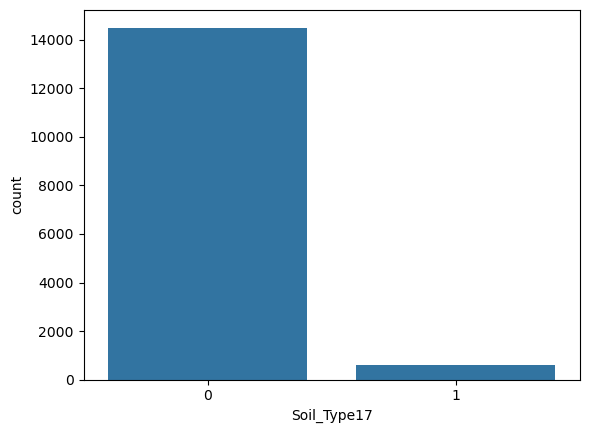

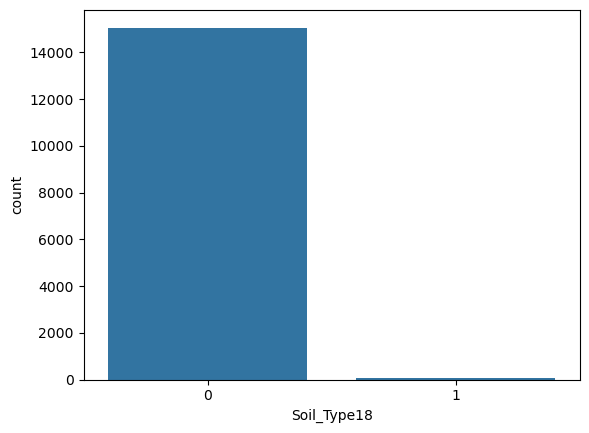

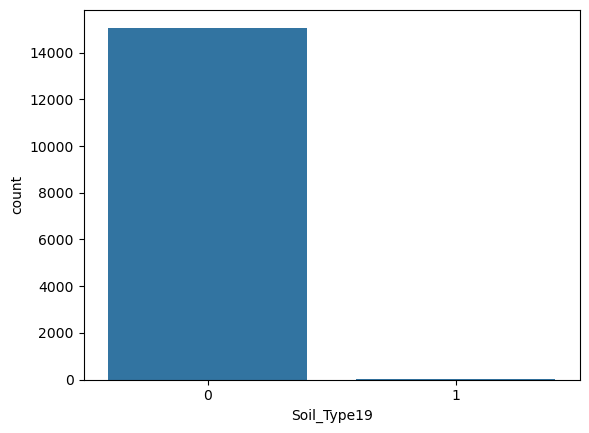

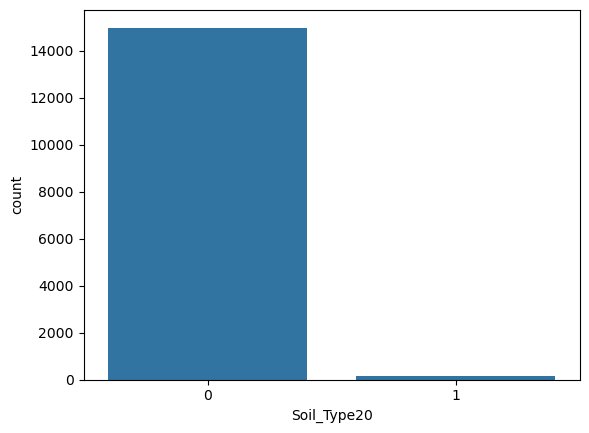

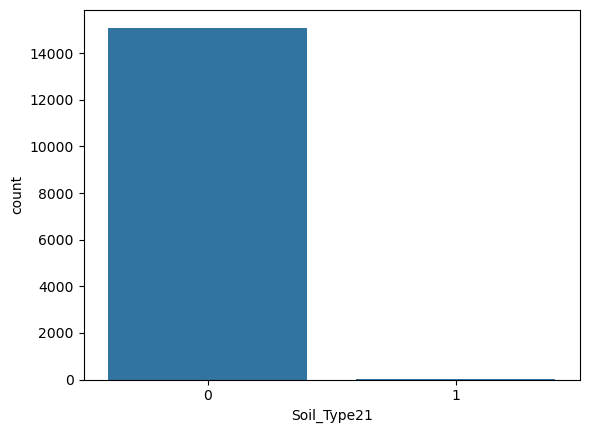

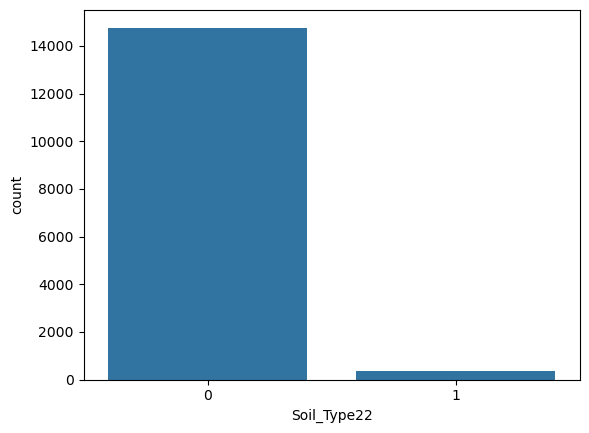

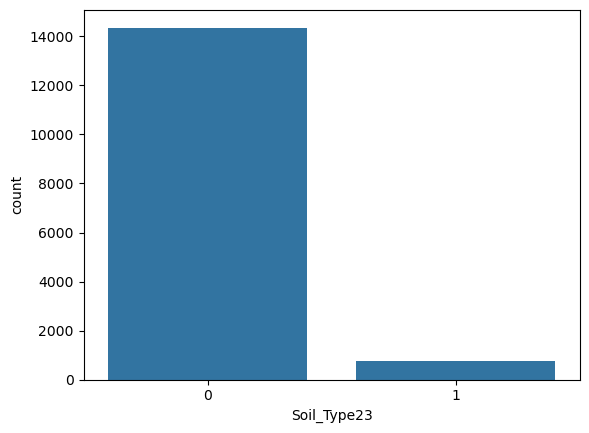

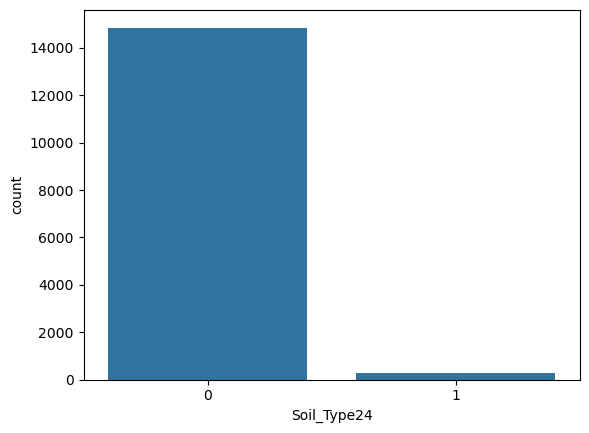

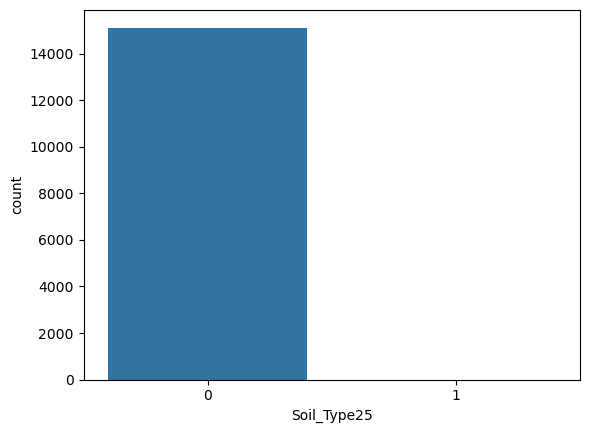

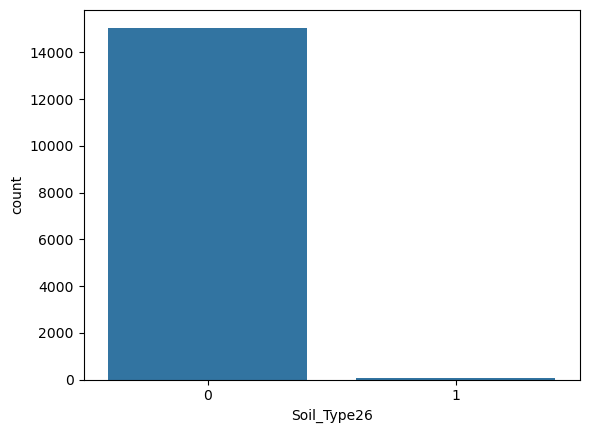

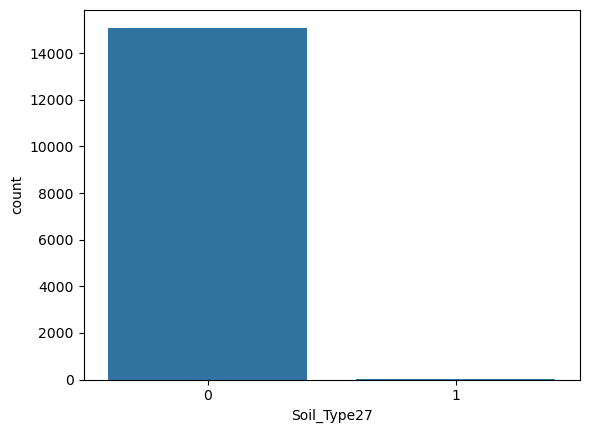

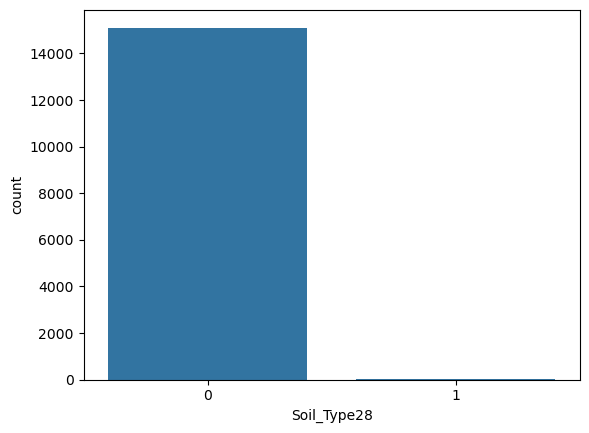

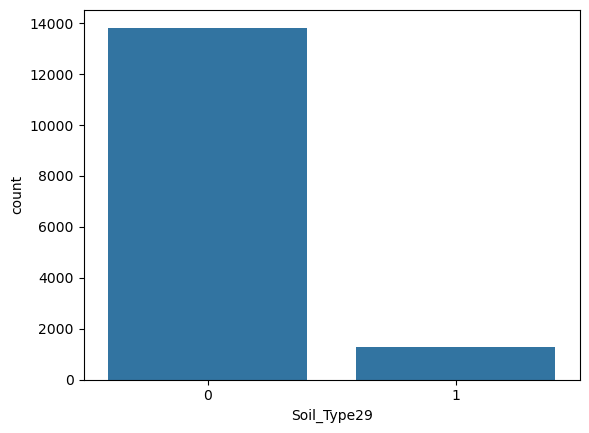

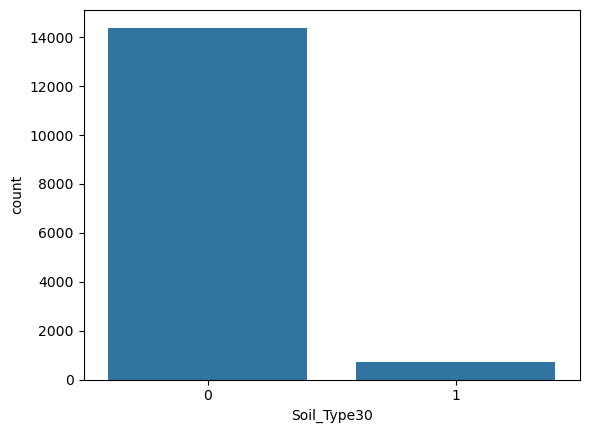

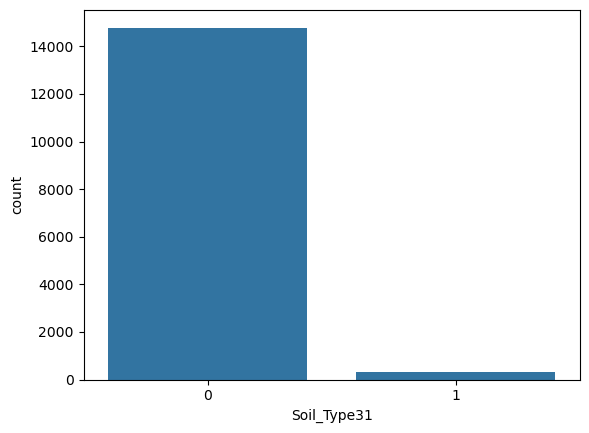

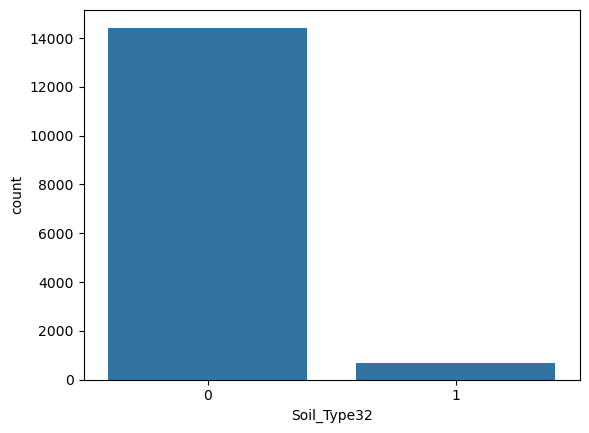

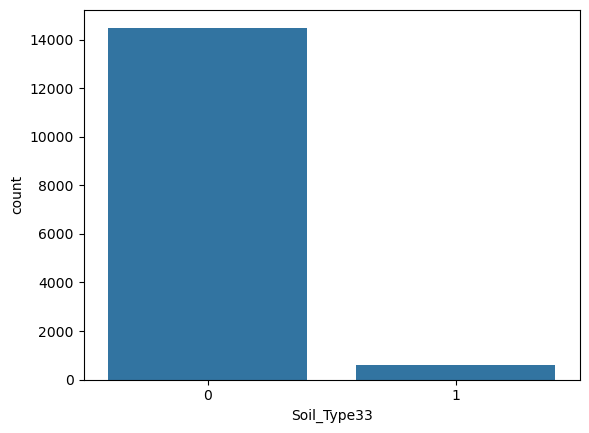

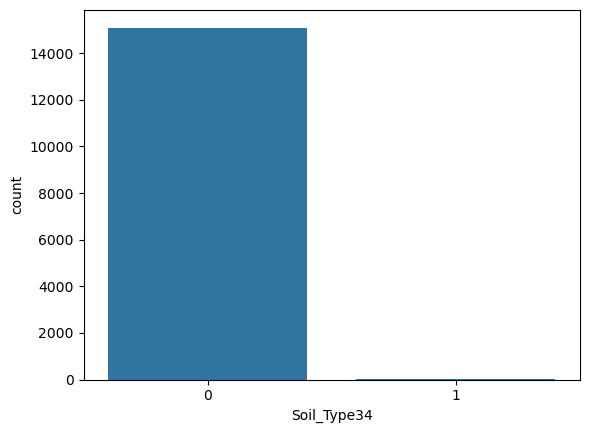

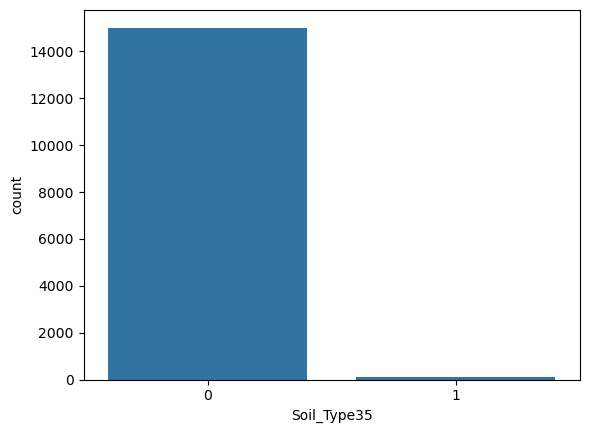

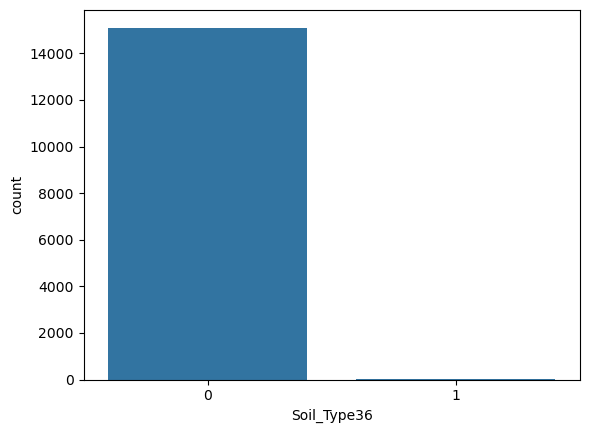

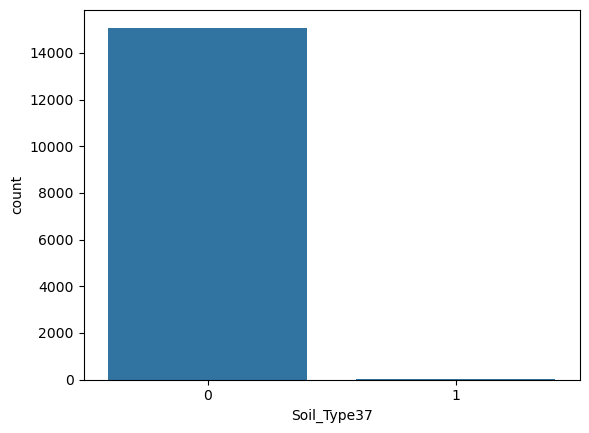

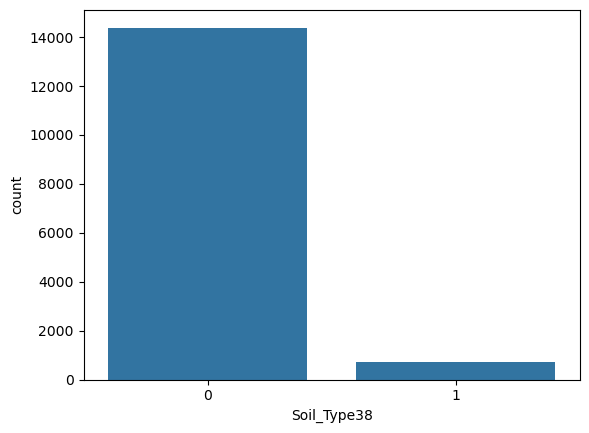

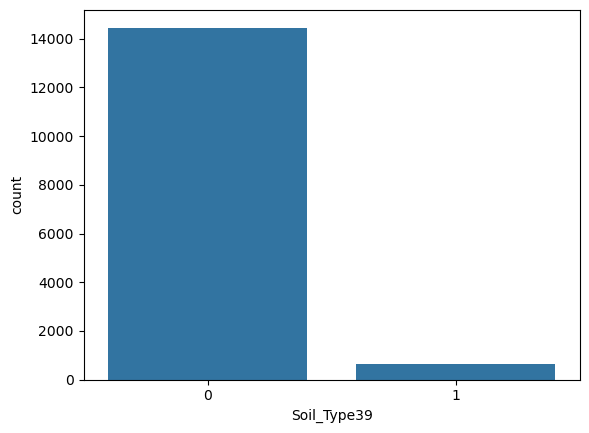

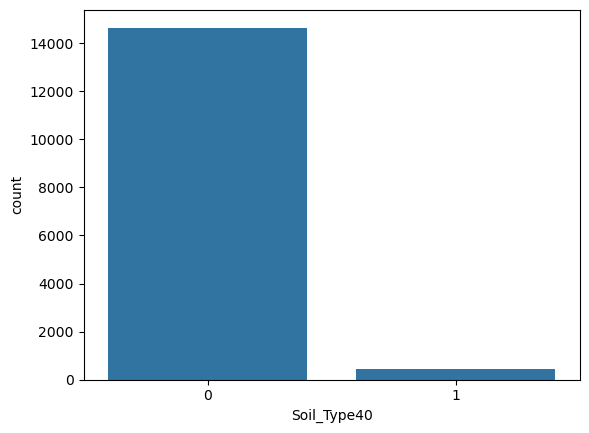

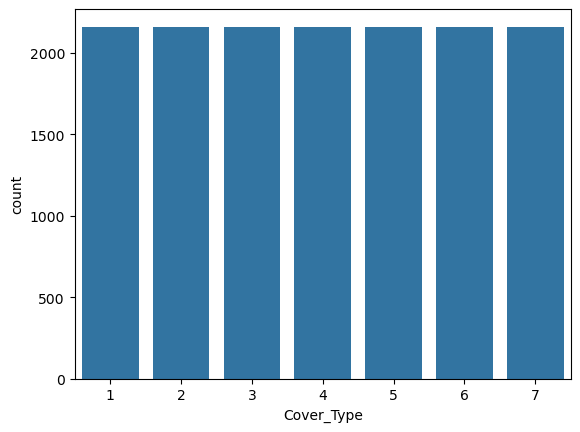

In [478]:
for col in categorial_features:
    plt.figure()
    sns.countplot(x=col, data=df)

## **3. Exploration Bi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Corrélations : 
    - 'Elevation' / 'Horizontal_Distance_To_Hydrology' : 0.41
    - 'Elevation' / 'Horizontal_Distance_To_Roadways' : 0.58
    - 'Elevation' / 'Horizontal_Distance_To_Fire_Points' : 0.44
    - 'Horizontal_Distance_To_Hydrology' / 'Vertical_Distance_To_Hydrology' : 0.65
    - 'Horizontal_Distance_To_Roadways' / 'Horizontal_Distance_To_Fire_Points' : 0.49
    - 'Slope' / 'Elevation' : -0.31
    - 'Slope' / 'Horizontal_Distance_To_Roadways' : -0.28
    - 'Slope' / 'Horizontal_Distance_To_Fire_Points' : -0.24
  - P-value : 
    - 'Horizontal_Distance_To_Roadways' / 'Horizontal_Distance_To_Fire_Points' : P-Value : 0.27
  - Observations :
    - 'Elevation' est corrélé à plusieurs variables, c'est un indice de multicolinéarité
    - les 'Distance_To_Hydrology' semble être relativement dépendante
    - 'Horizontal_Distance_To_Roadways' et 'Horizontal_Distance_To_Hydrology' ont des statistiques descriptives très similaire. Mais la p-value (Spearman) est élevé, la relation monotone pourrait être dû au hasard, car les stats sont similaires.

In [479]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- Visualisations de corrélations (heatmap, scatterplot) : 

In [480]:
continuous_corr = df[continuous_features].corr()

<Axes: >

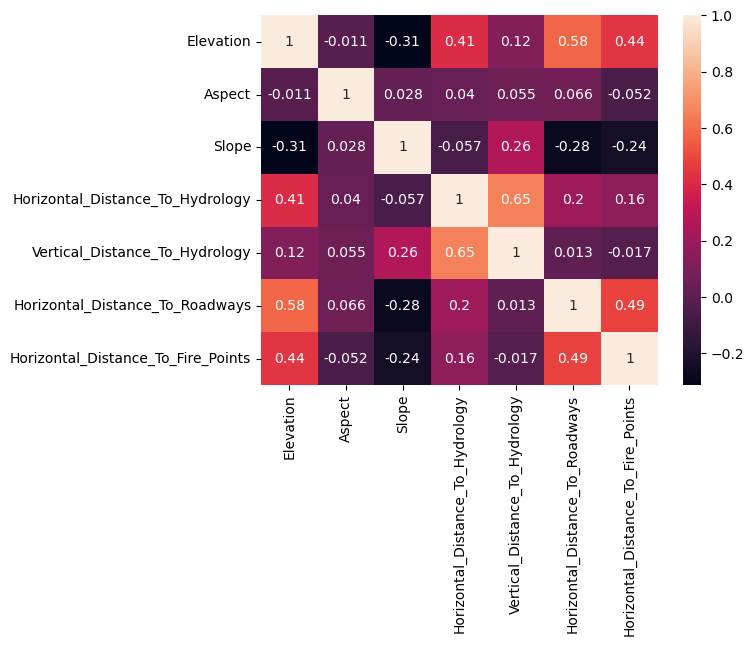

In [481]:
sns.heatmap(continuous_corr, annot=True, cbar=True)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Elevation'),
  Text(1, 0, 'Aspect'),
  Text(2, 0, 'Slope'),
  Text(3, 0, 'Horizontal_Distance_To_Hydrology'),
  Text(4, 0, 'Vertical_Distance_To_Hydrology'),
  Text(5, 0, 'Horizontal_Distance_To_Roadways'),
  Text(6, 0, 'Horizontal_Distance_To_Fire_Points')])

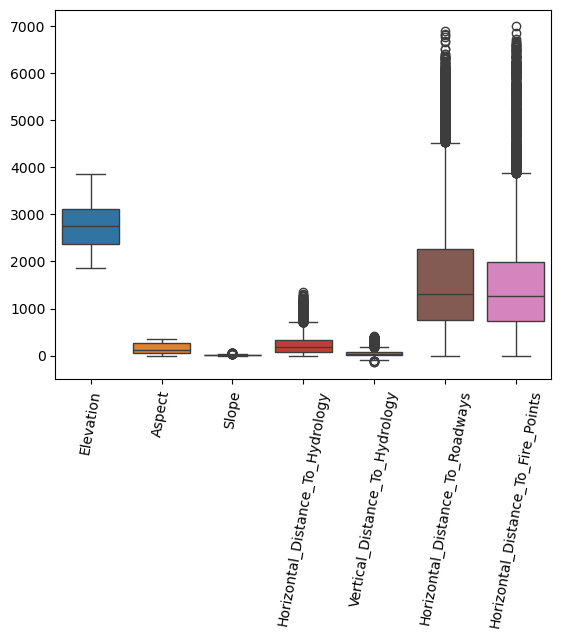

In [482]:
sns.boxplot(df[continuous_features])
plt.xticks(rotation=80)

- Statistiques de corrélations (pearson, spearman, kendall) : 

In [483]:
print(df["Horizontal_Distance_To_Roadways"].describe())
print(df["Horizontal_Distance_To_Fire_Points"].describe())

count   15117.00
mean     1714.19
std      1325.14
min         0.00
25%       764.00
50%      1316.00
75%      2270.00
max      6890.00
Name: Horizontal_Distance_To_Roadways, dtype: float64
count   15117.00
mean     1510.96
std      1099.96
min         0.00
25%       730.00
50%      1256.00
75%      1988.00
max      6993.00
Name: Horizontal_Distance_To_Fire_Points, dtype: float64


In [484]:
spearman_corr, spearman_p_value = stats.spearmanr(df[continuous_features])
spearman_corr_df = pd.DataFrame(spearman_corr, index=continuous_features, columns=continuous_features)
spearman_pval_df = pd.DataFrame(spearman_p_value, index=continuous_features, columns=continuous_features)

print("Correlation Spearman : ", spearman_corr_df)
print("\nP-Value Spearman : ", spearman_pval_df)

Correlation Spearman :                                      Elevation  Aspect  Slope  \
Elevation                                1.00   -0.01  -0.31   
Aspect                                  -0.01    1.00   0.05   
Slope                                   -0.31    0.05   1.00   
Horizontal_Distance_To_Hydrology         0.38    0.03   0.03   
Vertical_Distance_To_Hydrology           0.09    0.07   0.33   
Horizontal_Distance_To_Roadways          0.60    0.07  -0.28   
Horizontal_Distance_To_Fire_Points       0.51   -0.06  -0.24   

                                    Horizontal_Distance_To_Hydrology  \
Elevation                                                       0.38   
Aspect                                                          0.03   
Slope                                                           0.03   
Horizontal_Distance_To_Hydrology                                1.00   
Vertical_Distance_To_Hydrology                                  0.70   
Horizontal_Distance_To_Roadways

- ### Variables Continues et Catégorielles :
  - Corrélations : 
    - Distributions : 
      - Elevation / Wilderness_Area1 et Wilderness_Area2 : plage et densités de valeurs de 'Elevation' très différente entre les classes 0 et 1 des 'Wilderness'
      - Elevation / Wilderness_Area4 : plage de valeur opposé entre classe 0 et 1 de 'Wilderness'
      - Elevation / Cover_Type : plage relativement différente entre les classes, densité similaire entre classe [4, 5, 7], et [1, 2, 3, 6]
      - Slope / Wilderness_Area4 : outliers présent sur la classe 0 uniquement, densité plus grande proche de 0 pour classe 1
      - Horizontal_Distance_To_Roadways / Wilderness_Area1 : densités assez différentes
      - Horizontal_Distance_To_Roadways / Wilderness_Area2 : outliers présent sur classe 0 uniquement
      - Horizontal_Distance_To_Roadways / Wilderness_Area4 : densités et plage de valeurs très différentes entre les 2 classes
      - Horizontal_Distance_To_Roadways / Cover_Type : [1, 2], [3, 4, 5, 6] similaire
      - Horizontal_Distance_To_Fire_Points : idem que 'Horizontal_Distance_To_Roadways'
    - Tests de relation : 
        - T de Student (p-value < 0.05) : 
        - Mann-Whitney (p-value < 0.05): 
          - Wilderness_Area1 et 4 : différence significative entre les 2 classes avec toutes les variables continues.
          - Wilderness_Area2 : idem sauf 'Vertical_Distance_To_Hydrology'
          - Wilderness_Area3 : idem sauf 'Horizontal_Distance_To_Fire_Points'
        - ANOVA (p-value < 0.05 ) :
        - Kruskal-Wallis (p-value < 0.05 ) :
          - Hillshade_9am et 3pm : différences significatives entre au moins un des classes avec toutes les variables continues.
          - Hillshade_Noon : idem sauf 'Horizontal_Distance_To_Hydrology'
  - Skewness (>0.5 ou <-0.5) : `(décalé)` : 
    - Elevation / Cover_Type : 5 = -0.62 ; 7 = 1.07
    - Aspect /
      - Wilderness_Area1 : 1 = 1.01
      - Wilderness_Area3 : 0 = 0.56
      - Wilderness_Area4 : 0 = 0.52
      - Cover_Type : 4 = 1.02 ; 5 = 0.81
    - Slope / Cover_Type et Wilderness_Area : toutes les classes sont asymétriques
    - Distance / Cover_Type et Wilderness_Area : toutes les classes sont asymétriques
  - Variance (cv >1) :
    - Slope / Cover_Type (classe 4) : 1.37
    - Vertical_Distance_To_Hydrology / 
      - Wilderness_Area1 : 0 = 1.15 ; 1 =1.34
      - Wilderness_Area2 : 0 = 1.19 ; 1 = 1.24
      - Wilderness_Area3 : 0 = 1.20 ; 1 = 1.18
      - Wilderness_Area4 : 0 = 1.24 ; 1 = 1.09
      - Cover_Type : 1 = 1.35 ; 2 = 1.20 ; 4 = 1.45 ; 5 = 1.15 ; 6 = 1.05 ; 7 = 1.17
  - Observations :
    - les similitudes de corrélations (continue - catégorielle) entre 'To_Roadways' et 'To_Fire_Points' sont très similaire, possible redondance des données
    - toutes les features "Distance" semble avoir une forte asymétrie, seules ou accompagné de features catégorielles
    

In [485]:
print(continuous_features)
#categorial_features = categorial_features.drop([col for col in categorial_features if 'Soil_Type' in col])
print(categorial_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Visualisations de corrélations (boxplot, violonplot, barplot) : 

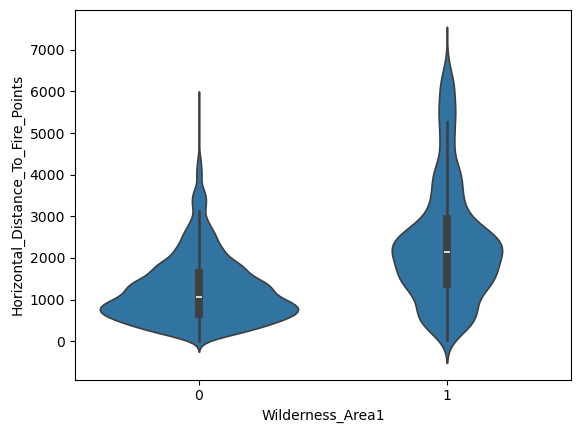

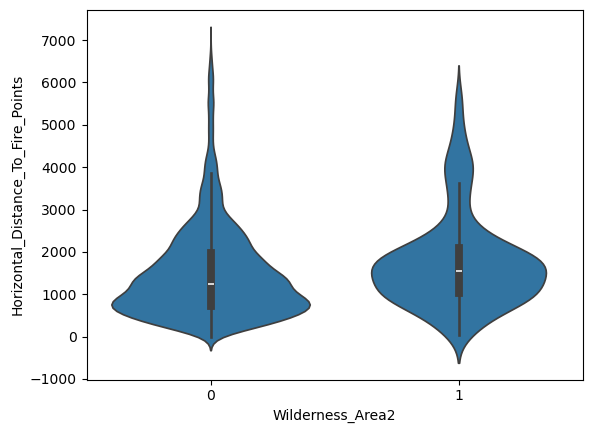

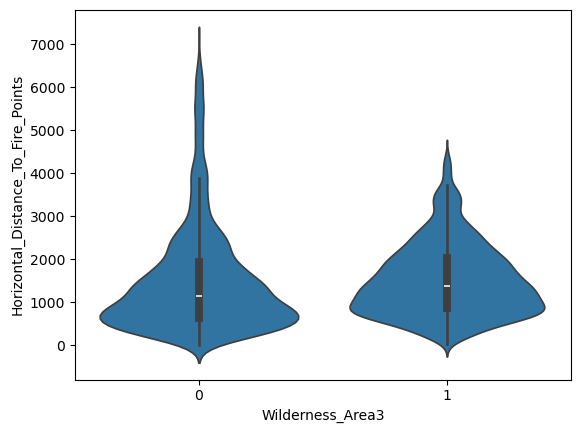

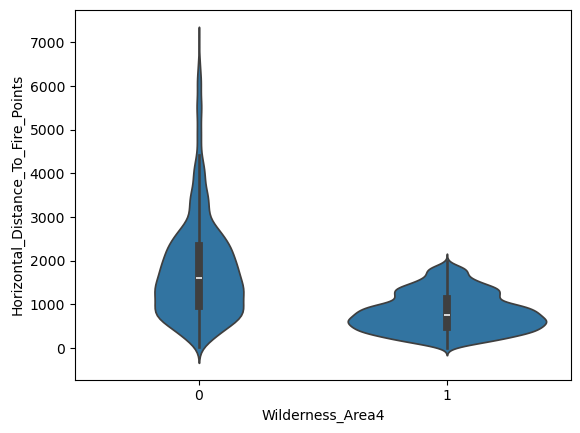

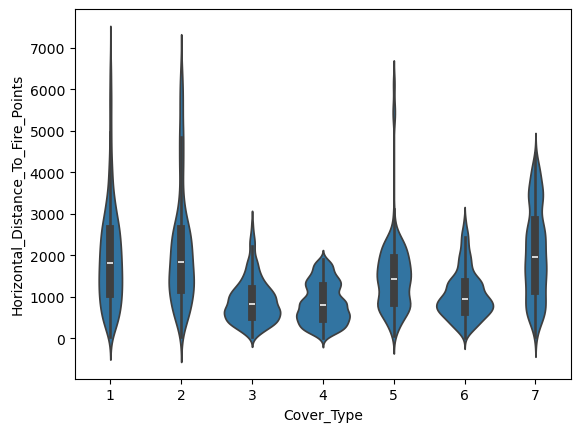

In [486]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    plt.figure()
    sns.violinplot(x=df[col], y=df["Horizontal_Distance_To_Fire_Points"])

- Statistiques de bases (mean, skew, var) : 

In [487]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


In [488]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    groupby = df.groupby(col)["Vertical_Distance_To_Hydrology"]
    skew = groupby.skew()
    skew = skew[(skew >= 0.5) | (skew <= -0.5)]
    print(skew)

Wilderness_Area1
0   1.40
1   1.61
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area2
0   1.50
1   0.80
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area3
0   1.23
1   1.61
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area4
0   1.63
1   1.05
Name: Vertical_Distance_To_Hydrology, dtype: float64
Cover_Type
1   1.80
2   1.68
3   0.87
4   1.42
5   1.04
6   1.05
7   1.40
Name: Vertical_Distance_To_Hydrology, dtype: float64


In [489]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    groupby = df.groupby(col)["Vertical_Distance_To_Hydrology"]
    coef_var = groupby.std() / groupby.mean()
    for value in coef_var:
        if value >= 1:
            print(coef_var)
            break

Wilderness_Area1
0   1.15
1   1.34
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area2
0   1.19
1   1.24
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area3
0   1.20
1   1.18
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area4
0   1.24
1   1.09
Name: Vertical_Distance_To_Hydrology, dtype: float64
Cover_Type
1   1.35
2   1.20
3   0.91
4   1.45
5   1.15
6   1.05
7   1.17
Name: Vertical_Distance_To_Hydrology, dtype: float64


- Statistiques de relations (t de Student, ANOVA, Kruskal-Wallis, CDF, point-biserial) : 

In [490]:
print(continuous_features)
print(categorial_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- T de Student (2 catégories) : 

- Mann-Whitney (2 catégories et données anormales) : 

In [491]:
for col in continuous_features:
    cat_col = "Wilderness_Area2"
    gr1 = df[df[cat_col] == 0][col]
    gr2 = df[df[cat_col] == 1][col]

    print(f"{cat_col} : {col} : ")
    u_stat, p_value = stats.mannwhitneyu(gr1, gr2)
    print(f"Mann-Whitney : u-stat{u_stat}, p-value : {p_value}")

Wilderness_Area2 : Elevation : 
Mann-Whitney : u-stat644293.5, p-value : 2.137613806664364e-215
Wilderness_Area2 : Aspect : 
Mann-Whitney : u-stat3383068.5, p-value : 0.0058652337942185695
Wilderness_Area2 : Slope : 
Mann-Whitney : u-stat4395085.5, p-value : 5.8662237907041856e-15
Wilderness_Area2 : Horizontal_Distance_To_Hydrology : 
Mann-Whitney : u-stat2568184.5, p-value : 1.9250597835156368e-29
Wilderness_Area2 : Vertical_Distance_To_Hydrology : 
Mann-Whitney : u-stat3509458.0, p-value : 0.1503770549573918
Wilderness_Area2 : Horizontal_Distance_To_Roadways : 
Mann-Whitney : u-stat4380218.5, p-value : 2.0633203468719305e-14
Wilderness_Area2 : Horizontal_Distance_To_Fire_Points : 
Mann-Whitney : u-stat2993403.0, p-value : 9.102317288491596e-12


- ANOVA (+2 catégories) : 

In [492]:
for col in continuous_features:
    cat_col = "Hillshade_3pm"
    gr = [df[df[cat_col] == cat][col] for cat in df[cat_col].unique()]

    print(f"{cat_col} : {col} : ")
    f_stat, p_value = stats.f_oneway(*gr)
    print(f"ANOVA : F-stat{f_stat}, p-value : {p_value}")

Hillshade_3pm : Elevation : 
ANOVA : F-stat4.8966370715885255, p-value : 1.0804974285273161e-119
Hillshade_3pm : Aspect : 
ANOVA : F-stat149.3952739698354, p-value : 0.0
Hillshade_3pm : Slope : 
ANOVA : F-stat74.12748549960196, p-value : 0.0
Hillshade_3pm : Horizontal_Distance_To_Hydrology : 
ANOVA : F-stat1.4652435288092562, p-value : 3.3188986089683697e-06
Hillshade_3pm : Vertical_Distance_To_Hydrology : 
ANOVA : F-stat3.5660597767875597, p-value : 6.244887215018806e-69
Hillshade_3pm : Horizontal_Distance_To_Roadways : 
ANOVA : F-stat5.2239645384486355, p-value : 1.137477750857668e-132
Hillshade_3pm : Horizontal_Distance_To_Fire_Points : 
ANOVA : F-stat3.4186308921973043, p-value : 1.3586351743702712e-63


- Kruskal-Wallis (+2 catégories et données anormales) : 

In [493]:
for col in continuous_features:
    cat_col = "Hillshade_Noon"
    gr = [df[df[cat_col] == cat][col] for cat in df[cat_col].unique()]

    print(f"{cat_col} : {col} : ")
    h_stat, p_value = stats.kruskal(*gr)
    print(f"Kruskal-Wallis : H-stat : {h_stat}, p-value : {p_value}")

Hillshade_Noon : Elevation : 
Kruskal-Wallis : H-stat : 1023.1922812880532, p-value : 3.6480480862502044e-134
Hillshade_Noon : Aspect : 
Kruskal-Wallis : H-stat : 2689.506235053637, p-value : 0.0
Hillshade_Noon : Slope : 
Kruskal-Wallis : H-stat : 7588.780637730809, p-value : 0.0
Hillshade_Noon : Horizontal_Distance_To_Hydrology : 
Kruskal-Wallis : H-stat : 233.72383677249155, p-value : 1.1468924165369166e-06
Hillshade_Noon : Vertical_Distance_To_Hydrology : 
Kruskal-Wallis : H-stat : 1017.0894863898185, p-value : 5.109774470255266e-133
Hillshade_Noon : Horizontal_Distance_To_Roadways : 
Kruskal-Wallis : H-stat : 1412.169064662402, p-value : 5.417202541001627e-209
Hillshade_Noon : Horizontal_Distance_To_Fire_Points : 
Kruskal-Wallis : H-stat : 464.56877341049875, p-value : 1.968877802204536e-36


- Point-Bisériale (catégories binaires) : 

- ### Variables Catégorielles (heatmap, cramer's-v, PMF, CDF) :
  - Corrélations : 
    - Distributions : 
      - Wilderness_Area3 / Wilderness_Area4 : semble corrélés, les 1 de 4 sont inexistant dans le 1 de 3
      - Wilderness_Area3 / Cover_Type : 4 de 'Cover_Type' est uniquement présent dans le 0 de 'Wilderness_Area3'
      - Cover_Type / Wilderness_Area4 : 1 de 'Wilderness' uniquement présent dans 3, 4 et 6 de 'Cover_Type'
    - Tests de relation : 
      - Cramer's V :
        - Wilderness_Area1 / WildernessArea_3 : 0.48
        - Wilderness_Area1 / Cover_Type : 0.52
        - WildernessArea_3 / WildernessArea_4 : 0.57
        - WildernessArea_4 / Cover_Type : 0.82
      - Fisher (p-value < 0.05) :
        - toutes les features 'Wilderness_Area' ont une dépendance entre elles
      - Tau de Kendall (p-value < 0.05 et tau > 0.5 ou <-0.5): 
        - Hillshade_9am / Hillshade_3pm : -0.67
        - Hillshade_3pm / Hillshade_Noon : 0.43
  - Statistiques de probabilité : 
    - PMF : 
    - CDF :
  - Observations :
    - 'Wilderness_Area3' et '4' pourrait ne pas être corrélée dû au déséquilibre de classe de '4'
    - possible multicolinéarité d'après les corrélations de Cramer's V et Kendall

In [494]:
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Visualisations de corrélations (boxplot, violonplot, barplot) : 

In [495]:
print(df["Wilderness_Area3"].value_counts())
print(df["Cover_Type"].value_counts())

Wilderness_Area3
0    8771
1    6346
Name: count, dtype: int64
Cover_Type
5    2160
1    2160
7    2160
3    2160
6    2160
4    2160
2    2157
Name: count, dtype: int64


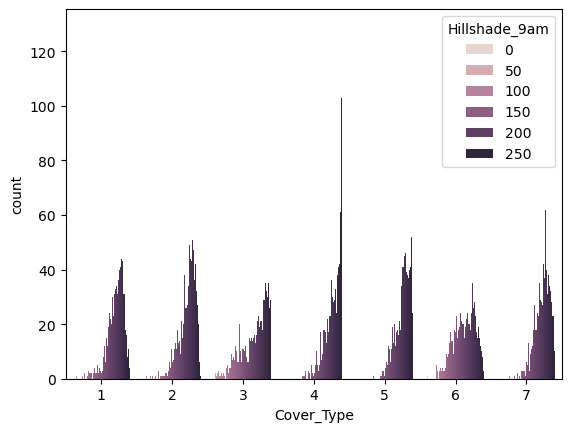

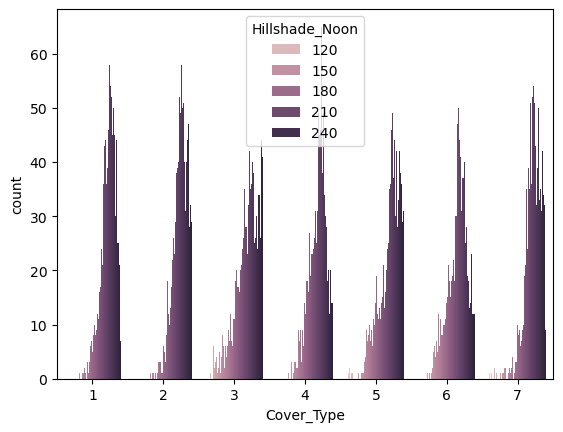

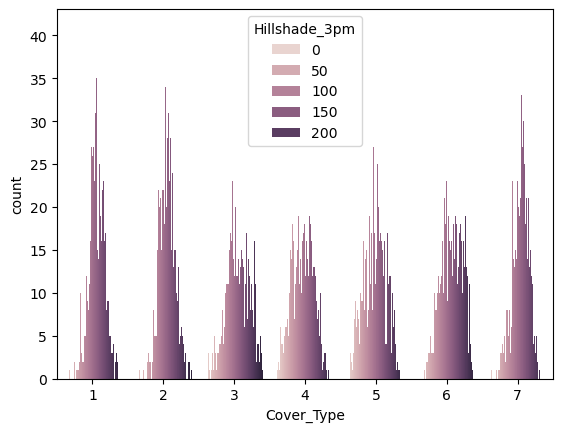

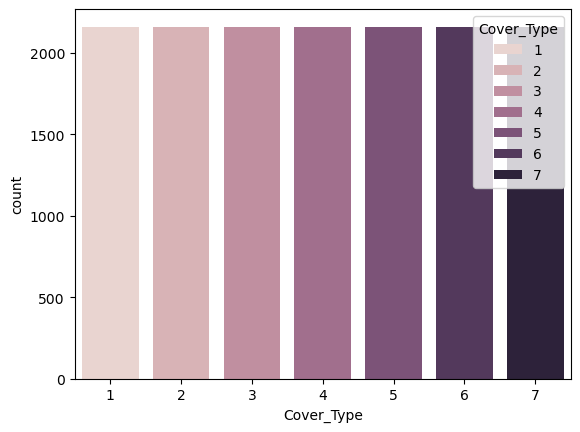

In [496]:
for col in [col for col in categorial_features if "Soil" not in col and "Wilderness" not in col]:
        plt.figure()
        sns.countplot(x=df["Cover_Type"], hue=df[col])

- Stastiques de corrélations (Cramér's V, chi2, fisher, kendall) : 

In [497]:
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Cramer's V (mesure d'association) : 

Text(0.5, 1.0, "Matrice de Cramer's V")

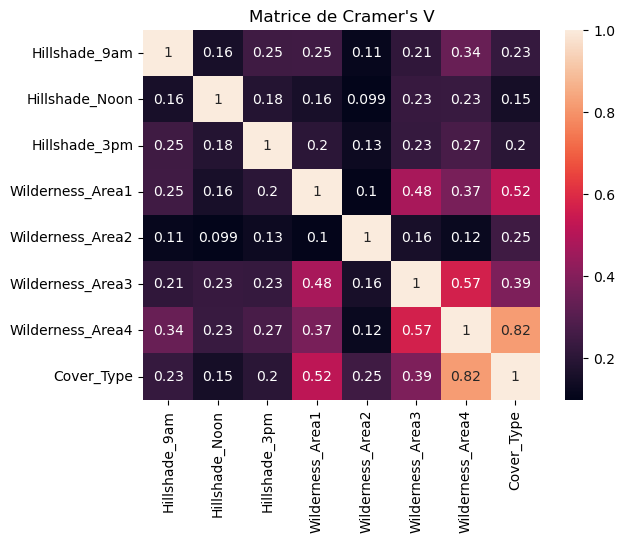

In [498]:
def cramers_v(chi2, n, k):
    return np.sqrt(chi2 / (n * (min(k) - 1)))
def cramers_v_matrix(df, categorial_vars):
    v_matrix = pd.DataFrame(index=categorial_vars, columns=categorial_vars)

    for var1 in categorial_vars:
        for var2 in categorial_vars:
            if var1 != var2:
                contingency_table = pd.crosstab(df[var1], df[var2])
                chi2, p, dof, excepted = stats.chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                k = contingency_table.shape
                v_matrix.loc[var1, var2] = cramers_v(chi2, n, k)
            else:
                v_matrix.loc[var1, var2] = 1

    return v_matrix.astype(float)

matrix = cramers_v_matrix(df, categorial_features.drop([col for col in categorial_features if "Soil" in col]))

sns.heatmap(matrix, annot=True)
plt.title("Matrice de Cramer\'s V")

- Fisher (test d'indépendance : 2 classes) : 

In [499]:
wilderness_col = [col for col in categorial_features if "Wilderness" in col]
for col1 in wilderness_col:
    for col2 in wilderness_col:
        if col1 != col2:
            oddsratio, p_value = stats.fisher_exact(pd.crosstab(df[col1], df[col2]))
            print(col1, " : ", col2)
            print("Odds Ratio : ", oddsratio)
            print("P-value : ", p_value)

Wilderness_Area1  :  Wilderness_Area2
Odds Ratio :  0.0
P-value :  1.2103448001883371e-60
Wilderness_Area1  :  Wilderness_Area3
Odds Ratio :  0.0
P-value :  0.0
Wilderness_Area1  :  Wilderness_Area4
Odds Ratio :  0.0
P-value :  0.0
Wilderness_Area2  :  Wilderness_Area1
Odds Ratio :  0.0
P-value :  1.2103448001883371e-60
Wilderness_Area2  :  Wilderness_Area3
Odds Ratio :  0.0
P-value :  3.4320038366967073e-121
Wilderness_Area2  :  Wilderness_Area4
Odds Ratio :  0.0
P-value :  2.7777341465802877e-82
Wilderness_Area3  :  Wilderness_Area1
Odds Ratio :  0.0
P-value :  0.0
Wilderness_Area3  :  Wilderness_Area2
Odds Ratio :  0.0
P-value :  3.4320038366967073e-121
Wilderness_Area3  :  Wilderness_Area4
Odds Ratio :  0.0
P-value :  0.0
Wilderness_Area4  :  Wilderness_Area1
Odds Ratio :  0.0
P-value :  0.0
Wilderness_Area4  :  Wilderness_Area2
Odds Ratio :  0.0
P-value :  2.7777341465802877e-82
Wilderness_Area4  :  Wilderness_Area3
Odds Ratio :  0.0
P-value :  0.0


- Tau de Kendall (corrélation ordinale) : 

In [500]:
wilderness_col = [col for col in categorial_features if "Hillshade" in col]
for col1 in wilderness_col:
    for col2 in wilderness_col:
        if col1 != col2:
            tau, p_value = stats.kendalltau(df[col1], df[col2])
            print(col1, " : ", col2)
            print("Tau : ", tau)
            print("P-value : ", p_value)

Hillshade_9am  :  Hillshade_Noon
Tau :  -0.10385712382406924
P-value :  8.326767968996291e-80
Hillshade_9am  :  Hillshade_3pm
Tau :  -0.6739415832052541
P-value :  0.0
Hillshade_Noon  :  Hillshade_9am
Tau :  -0.10385712382406923
P-value :  8.326767968996291e-80
Hillshade_Noon  :  Hillshade_3pm
Tau :  0.42714007394017317
P-value :  0.0
Hillshade_3pm  :  Hillshade_9am
Tau :  -0.673941583205254
P-value :  0.0
Hillshade_3pm  :  Hillshade_Noon
Tau :  0.4271400739401731
P-value :  0.0


- Statistiques de probabilités (CDF, PMF) : 

In [501]:
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- PMF (variable discrète) : 

- CDF (variable ordinale) : 



---


## **4. Exploration Multi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation, régression/classification) :
  - Corrélations : 
    - Distributions :
      - Horizontal_Distance_To_Hydrology / Vertical_Distance_To_Hydrology / Elevation : les 3 montrent une certaines corrélations
      - Horizontal_Distance_To_Fire_Points / Horizontal_Distance_To_Roadways / Elevation : potentielle corrélation
    - Tests de relation : 
      - PCA (valeurs égales) :
        - Elevation / Aspect / Vertical_Distance_To_Hydrology : même coefficient dans PC4
        - Horizontal_Distance_To_Hydrology / Horizontal_Distance_To_Roadways / Aspect : coefficient similaire dans PC5
        - Horizontal_Distance_To_Hydrology / Vertical_Distance_To_Hydrology / Horizontal_Distance_To_Fire_Points : même coefficient dans PC3
        - Horizontal_Distance_To_Fire_Points / Aspect : même coefficient dans PC7 et PC6
        - Horizontal_Distance_To_Roadways / Horizontal_Distance_To_Fire_Points / Elevation : coef similaire dans PC1
      - VIF (> 5) : 
        - Elevation : 13.63
        - Slope : 5.15
    - Modélisation (p-value < 0.05 et [0.025, 0.975] ∉ 0):  
      - Elevation : effet significatif et robuste sur la classification
      - Supression de Elevation : Aspect / Slope / Horizontal_Distance_To_Hydrology : grande variation de leur effet sur la classification (change selon la classe)
  - Observations :
    - possible multicolinéarité entre les 'Distance_To_Hydrology' et 'Elevation'
    - toutes les variables font potentiellement preuve d'une grande multicolinéarité, mais surtout "Elevation" (VIF)
    - la suppression de 'Horizontal_Distance_To_Hydrology' dans la modélisation n'impacte étonnemment pas les effets de 'Vertical_Distance_To_Hydrology'
    - la suppression de 'Horizontal_Distance_To_Roadways' dans la modélisation n'impacte étonnemment pas les effets de 'Horizontal_Distance_To_Fire_Points', malgré la corrélation observé lors de l'analyse Bi-variable
    - le VIF moyen de 'Slope' était une fausse alerte, aucune multi-colinéarité 
  - Conclusion : 
    - la variable ayant le plus grand impact sur la classfication et faisant preuve de la plus grande multi-colinéarité est 'Elevation'. Elle influt les effet de +/- toutes les autres variables continues.


In [502]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- Visualisations des corrélations (3d scatterplot, pairplot, heatmap, 3d surface plot) : 

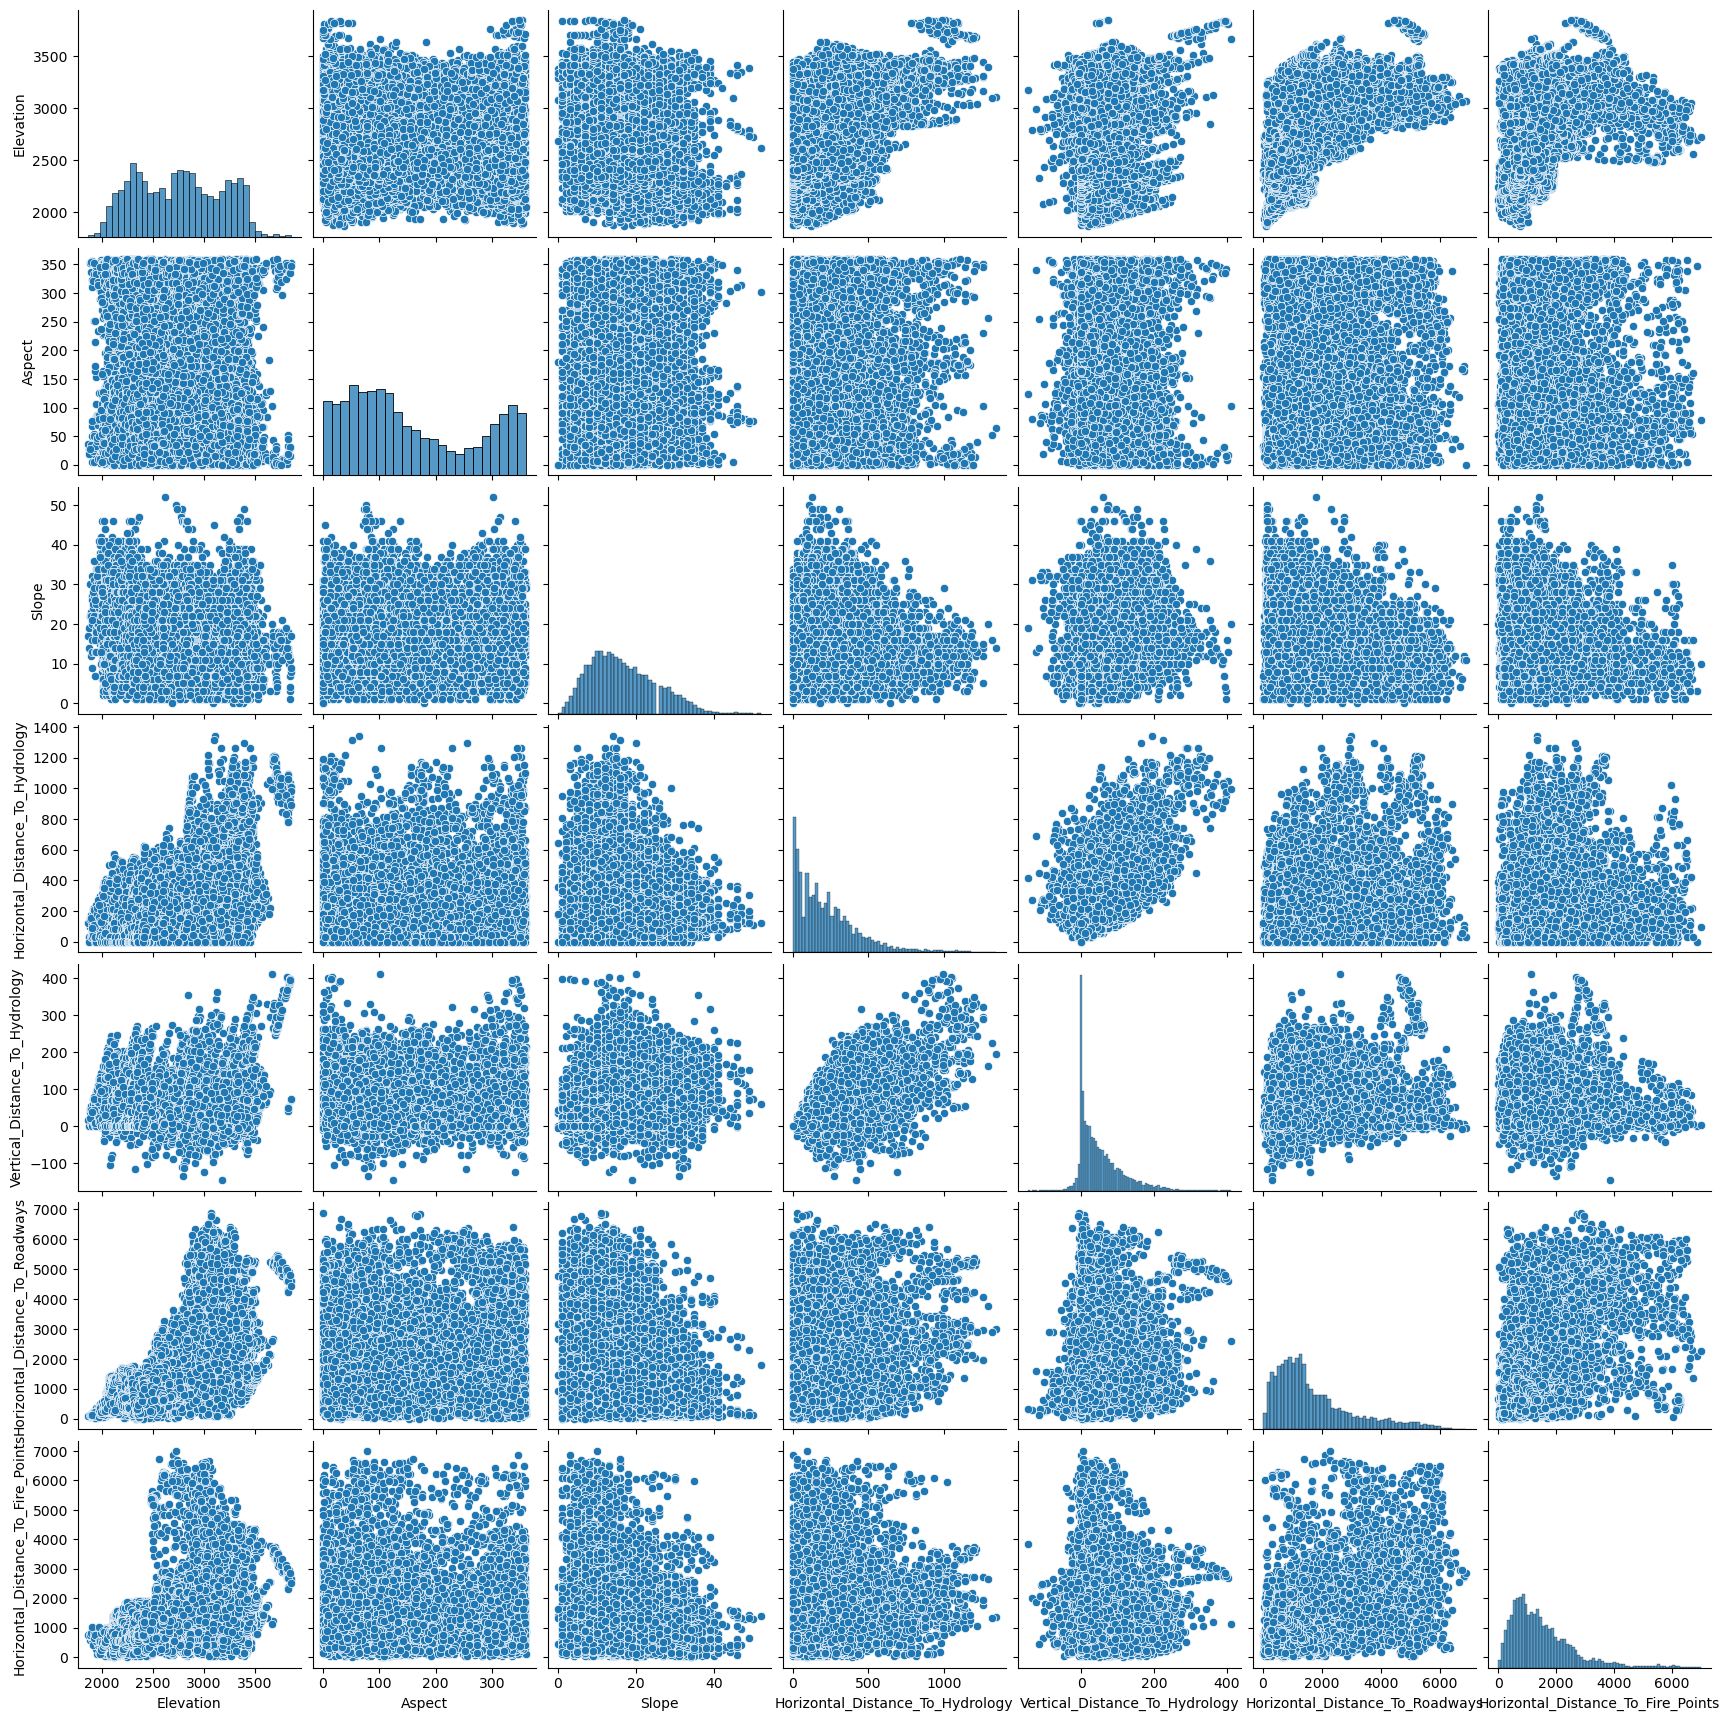

In [503]:
sns.pairplot(df[continuous_features])

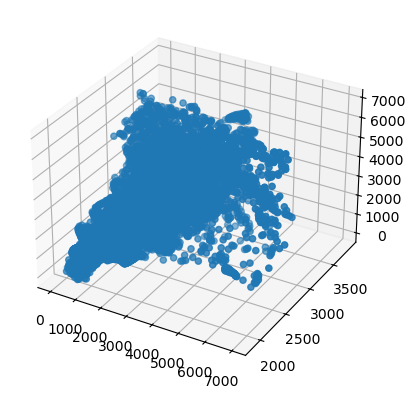

In [504]:
ax = plt.axes(projection="3d")
ax.scatter(df["Horizontal_Distance_To_Fire_Points"], df["Elevation"], df["Horizontal_Distance_To_Roadways"])

- Tests stastistiques (PCA, VIF) : 

In [505]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- PCA : 

In [506]:
continuous_X_scaled = StandardScaler().fit_transform(df[continuous_features])
pca = PCA()
continuous_X_pca = pca.fit_transform(continuous_X_scaled)

Contribution des variables dans chaque composante : 
      Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
PC1       0.55    0.02  -0.28                              0.38   
PC2      -0.04    0.11   0.41                              0.52   
PC3      -0.02    0.98  -0.02                             -0.08   
PC4      -0.02   -0.02   0.78                             -0.30   
PC5      -0.42    0.13  -0.24                              0.10   
PC6       0.66    0.10   0.22                              0.07   
PC7      -0.29   -0.01   0.20                              0.69   

     Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
PC1                            0.17                             0.50   
PC2                            0.69                            -0.18   
PC3                           -0.07                             0.14   
PC4                           -0.02                             0.29   
PC5                            0.13              

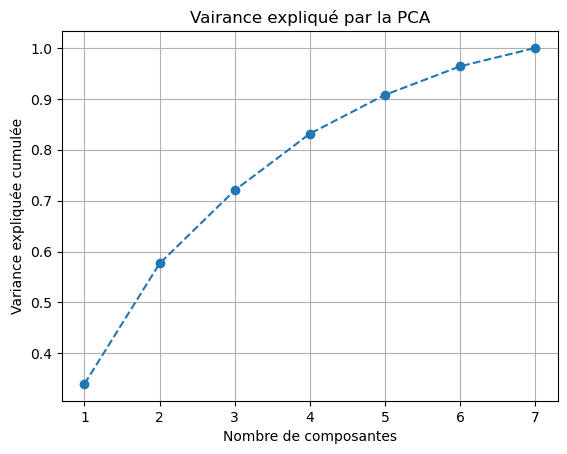

In [507]:
plt.plot(range(1, len(continuous_features) + 1), np.cumsum(pca.explained_variance_ratio_), marker="o", linestyle="--")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Vairance expliqué par la PCA")
plt.grid()

components_df = pd.DataFrame(pca.components_, columns=continuous_features, index=[f"PC{i+1}" for i in range(len(continuous_features))])
print("Contribution des variables dans chaque composante : \n", components_df)

- VIF : 

In [508]:
vif_data = pd.DataFrame()
vif_data["Features"] = continuous_features
vif_data["VIF"] = [variance_inflation_factor(df[continuous_features].values, i) for i in range(len(continuous_features))]
print(vif_data)

                             Features   VIF
0                           Elevation  0.00
1                              Aspect -0.00
2                               Slope  0.02
3    Horizontal_Distance_To_Hydrology -0.00
4      Vertical_Distance_To_Hydrology  0.00
5     Horizontal_Distance_To_Roadways  0.00
6  Horizontal_Distance_To_Fire_Points  0.00


- Modélisation simple (régression/classification avec statsmodel) : 

In [509]:
X = df[continuous_features]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.913631
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15069
Method:                           MLE   Df Model:                           42
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.5305
Time:                        16:11:44   Log-Likelihood:                -13811.
converged:                       True   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 26.6221      0.820   

In [510]:
X = df[['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.924272
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15075
Method:                           MLE   Df Model:                           36
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.5250
Time:                        16:11:45   Log-Likelihood:                -13972.
converged:                       True   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 26.3830      0.805   

- ### Variables Continues et Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF, régression/classification) :
  - Corrélations : 
    - Distributions :
      - Horizontal_Distance_To_Roadways / Elevation / Wilderness_Area1 : montre une corrélation, la distinction des classes sont évidentes
      - Horizontal_Distance_To_Fire_Points / Elevation / Wilderness_Area1 : idem
      - Horizontal_Distance_To_Fire_Points / Horizontal_Distance_To_Roadways / Wilderness_Area1 : idem
      - Continuous_Features / Elevation / Wilderness_Area3 : nette multicolinéarité avec toutes le variables continues et Elevation
    - Tests de relation : 
      - MANOVA (λ→0 et p-value < 0.05) :
        - Elevation / Continuous_Features / Wilderness_Area1-2-3 : valeur de lambda relativement modéré, mais reste la même tant que 'Elevation' est présent
      - ANOVA (sum_sq, F→∞ et p-value < 0.05):
        - Continuous_Features / Hillshade_9am-Noon-3pm : semble avoir un bon impact sur tous les variables continues
        - Continuous_Features//{Distance_To_Hydrology} / Wilderness_Area1-2-3 : l'impact des 'Wilderness' est significatif 
        - Continuous_Features//{Horizontal_To_Hydrology} / Cover_Type : la p-value est toujours == 0, impact significatif
      - ANCOVA (sum_sq, F→∞ et p-value < 0.05):
        - les résultats de multicolinéarité ne change pas, même avec une variable continue de covariance
    - Modélisation (p-value < 0.05 et [0.025, 0.975] ∉ 0) :
      - Suppression de 'Elevation' : 'Hillshade_X' : les 'Hillshade' explique bien mieux la classification, mais le score diminue
      - Suppression des 'Hillshade_X' : Aspect et Slope : leurs effets change, majoritairement une augmentation de la p-value
  - Observations :
    - 'Elevation' fait preuve d'une grande multicolinéarité avec les 'Wilderness_Area1-2-3' et moyenne avec les 'Hillshade_Noon-3pm' et 'Cover_Type'
    - les 'Hillshade' sont multicolinéaire avec toutes les variables continues
    - idem pour les 'Wilderness_Area' sauf sur les 'Distance_To_Hydrology'
    - la target 'Cover_Type' est dépendantes des variables continues sauf les 'Horizontal_Distance'
    - 'Wilderness_Area2-3' empêchent l'estimation des coefficients lors de la modélisation, sûrement dû à la multicolinéarité
    - la suppression de 'Elevation' ne change absolument pas les effets des 'Wilderness' sur le modèle, malgré la multicolinéarité
  - Conclusion : 
    - 'Elevation' est multicolinéaire avec toutes les variables catégorielles
    - 'Wilderness_Area1-2-3' sont multicolinéaire avec presque toutes les variables continues
    - 'Hillshade_X' influt positivement les effets de 'Aspect' et 'Slope' sur le modèle
    - une partie des 'Wilderness_AreaX' devront être supprimé pour le fonctionnement du modèle

In [511]:
print(continuous_features)
print(categorial_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Visualisations des corrélations (boxplot, violonplot, histplot, catplot, pairplot hue=Category) : 

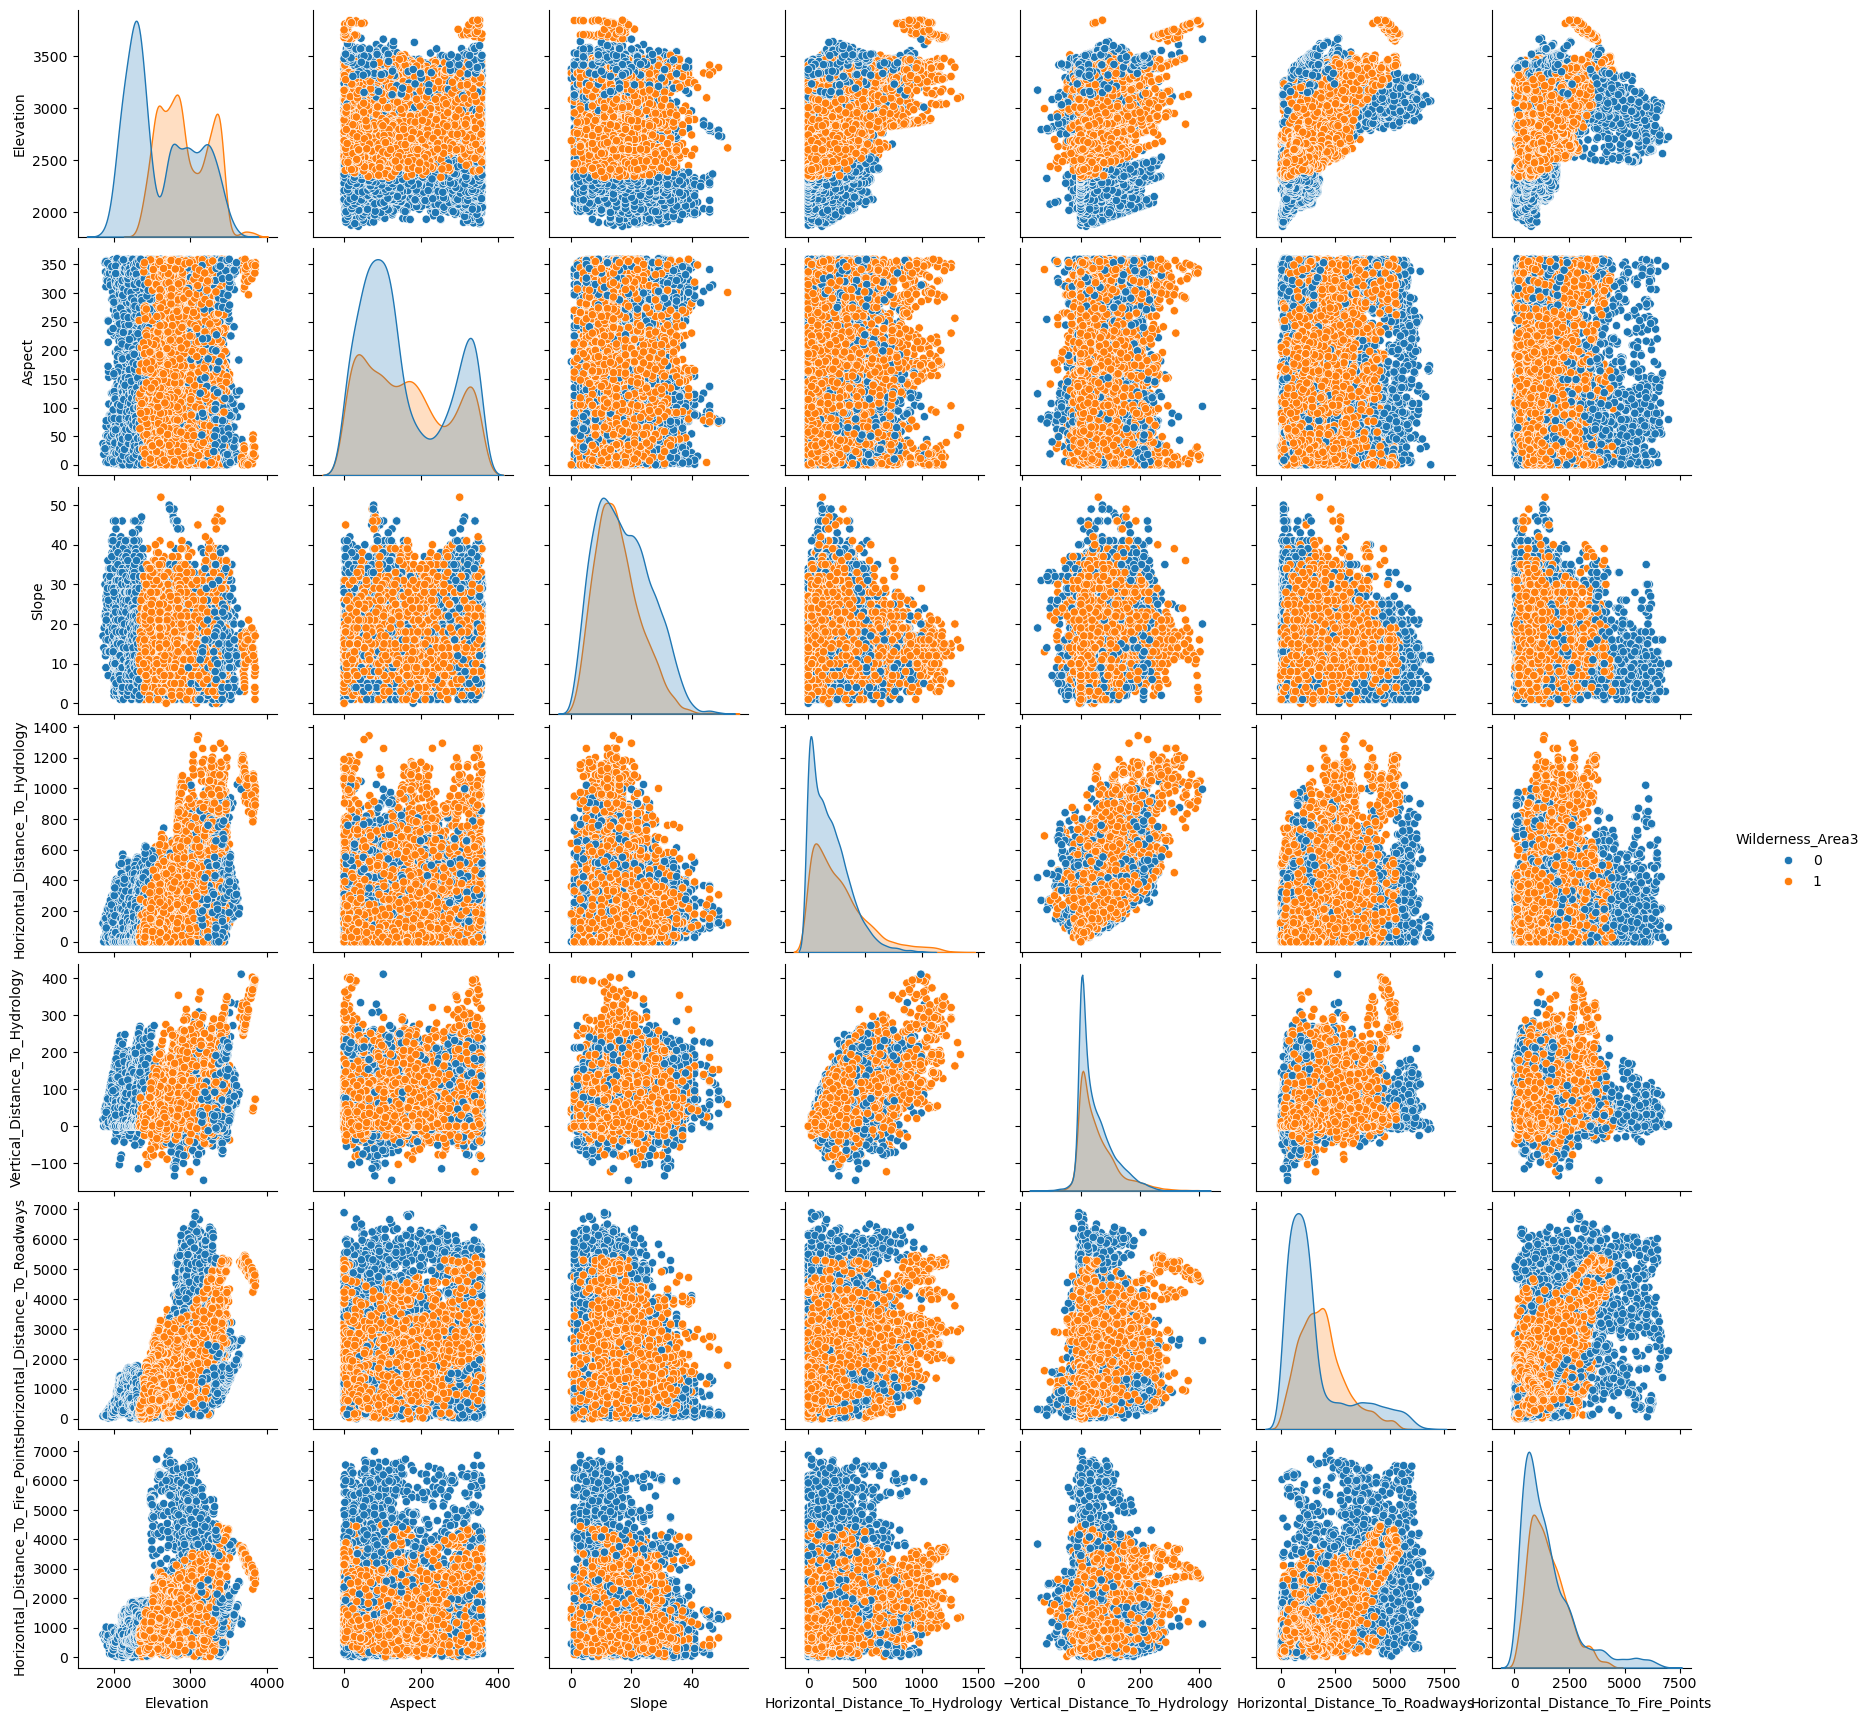

In [512]:
sns.pairplot(data=df, vars=continuous_features, hue="Wilderness_Area3")

- Tests statistiques (MANOVA, ANOVA, ANCOVA) :

In [513]:
print(continuous_features)
print(categorial_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- MANOVA (>=1 vars continues et >=1 vars catégorielles) : 

In [514]:
model = manova.MANOVA.from_formula("Elevation + Horizontal_Distance_To_Fire_Points ~ Wilderness_Area1 + Wilderness_Area2 + Wilderness_Area3", data=df)
print(model.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept         Value  Num DF   Den DF     F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda  0.0373 2.0000 15112.0000 195126.8969 0.0000
         Pillai's trace  0.9627 2.0000 15112.0000 195126.8969 0.0000
 Hotelling-Lawley trace 25.8241 2.0000 15112.0000 195126.8969 0.0000
    Roy's greatest root 25.8241 2.0000 15112.0000 195126.8969 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
      Wilderness_Area1    Value  Num DF   Den DF    F Value   Pr > F
--------------------------------------------------------------------
            Wilks' lambda 0.4268 2.0000 15112.0000 10149

- ANOVA (1 var continue et >=1 catégorielles): 

In [515]:
model = smf.ols("Vertical_Distance_To_Hydrology ~ Wilderness_Area1 + Wilderness_Area2 + Wilderness_Area3 + Wilderness_Area4 + Hillshade_9am + Hillshade_Noon + Hillshade_3pm + Cover_Type", data=df).fit()
print(anova_lm(model))

                       df      sum_sq    mean_sq      F  PR(>F)
Wilderness_Area1     1.00   775327.84  775327.84 225.82    0.00
Wilderness_Area2     1.00     1630.53    1630.53   0.47    0.49
Wilderness_Area3     1.00    14190.47   14190.47   4.13    0.04
Wilderness_Area4     1.00        0.45       0.45   0.00    0.99
Hillshade_9am        1.00   309523.17  309523.17  90.15    0.00
Hillshade_Noon       1.00  1193921.53 1193921.53 347.74    0.00
Hillshade_3pm        1.00  1689177.80 1689177.80 491.99    0.00
Cover_Type           1.00    97489.66   97489.66  28.40    0.00
Residual         15109.00 51874154.46    3433.33    NaN     NaN


- ANCOVA (1 continue + 1 catégorielle et + 1 covariable continue) : 

In [516]:
model = smf.ols("Slope ~ Wilderness_Area1 + Wilderness_Area2 + Wilderness_Area3 + Wilderness_Area4 + Hillshade_9am + Hillshade_Noon + Hillshade_3pm + Cover_Type + Horizontal_Distance_To_Fire_Points", data=df).fit()
print(anova_lm(model))

                                         df    sum_sq   mean_sq        F  \
Wilderness_Area1                       1.00  25179.44  25179.44  2920.03   
Wilderness_Area2                       1.00   7277.00   7277.00   843.90   
Wilderness_Area3                       1.00  60894.49  60894.49  7061.86   
Wilderness_Area4                       1.00    126.22    126.22    14.64   
Hillshade_9am                          1.00  26487.49  26487.49  3071.72   
Hillshade_Noon                         1.00 362151.73 362151.73 41998.27   
Hillshade_3pm                          1.00 467287.93 467287.93 54190.79   
Cover_Type                             1.00    125.53    125.53    14.56   
Horizontal_Distance_To_Fire_Points     1.00    205.56    205.56    23.84   
Residual                           15108.00 130276.50      8.62      NaN   

                                    PR(>F)  
Wilderness_Area1                      0.00  
Wilderness_Area2                      0.00  
Wilderness_Area3            

- Modélisation simple (régression/classification avec statsmodel) : 

In [517]:
X = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
     'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', "Wilderness_Area1"]]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

         Current function value: 0.802593
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15045
Method:                           MLE   Df Model:                           66
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.5875
Time:                        16:12:38   Log-Likelihood:                -12133.
converged:                      False   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 19.2514      3.161      6.091      0.000      13.056      

In [518]:
X = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
     "Wilderness_Area1"]]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

         Current function value: 0.885646
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15063
Method:                           MLE   Df Model:                           48
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.5449
Time:                        16:12:39   Log-Likelihood:                -13388.
converged:                      False   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 26.7066      0.826     32.333      0.000      25.088      

- ### Variables Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, CDF, régression/classification) :
  - Corrélations : 
    - Distributions :
      - Wilderness_Area3 / Cover_Type / Wilderness_Area4 : si 'Wilderness_Area4' = 1, Cover_Type semble n'avoir que les classe 3, 4, 6, uniquement pour la classe 0 de 'Wilderness_Area3'
      - Wilderness_Area3 / Cover_Type / Soil_Type : potentielle multicolinéarité
    - Tests de relation : 
      - Chi2 (p-value < 0.05) :
        - Wilderness_AreaX / Cover_Type : forte association 
        - Wilderness_AreaX / Soil_Type : forte association
        - Wilderness_AreaX / Cover_Type / Soil_Type : idem
      - Cramèr's V (>0.50) : 
        - Wilderness_Area4 / Soil_Type / Cover_Type : 0.82 de corrélation, multicolinéarité très probable
        - Wilderness_Area1 / Soil_Type / Cover_Type : idem
        - Wilderness_Area3 / Wilderness_Area4 / Soil_Type : grande corrélation
      - Freeman-Halton (p-value < 0.05) :
      - Cochran-Mantel-Haenszel (p-value < 0.05):
    - Modélisation (p-value < 0.05 et [0.025, 0.975] ∉ 0): 
      - Simple : 
        - Suppression de 'Soil_Type' : augmente la p-value de certaines variables pour la classe 7 de la target
      - Log-Linéaire : 
        - Wilderness_AreaX / Soil_Type : dépendantes 
  - Observations :
  - Conclusion :
    - création d'une variable 'Soil_Type' regroupant tous les types de sol avec tous les 'Soil_TypeX', qui seront supprimés
    - les Wilderness_Area, Soil_Type et Cover_Type font preuve d'une multicolinéarité flagrante

In [523]:
df["Soil_Type"] = df[[col for col in categorial_features if "Soil" in col]].idxmax(axis=1)
df["Soil_Type"] = df["Soil_Type"].astype("category").cat.codes
categorial_features = [col for col in categorial_features if "Soil" not in col]
categorial_features.append("Soil_Type")

In [524]:
print(categorial_features)

['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Cover_Type', 'Soil_Type']


- Visualisations des corrélations (heatmap, pairplot, catplot, facetgrid, MCA) : 

In [525]:
print(df["Soil_Type"].value_counts())

Soil_Type
1     2142
20    1291
21     962
32     843
14     757
30     728
22     725
24     690
31     657
35     650
10     623
25     614
7      612
4      476
33     459
2      406
0      355
13     345
23     332
15     257
3      227
5      169
34     165
11     139
6      114
27     102
8       60
17      54
9       46
29      34
26      22
12      16
18      15
37      10
28      10
19       8
36       1
16       1
Name: count, dtype: int64


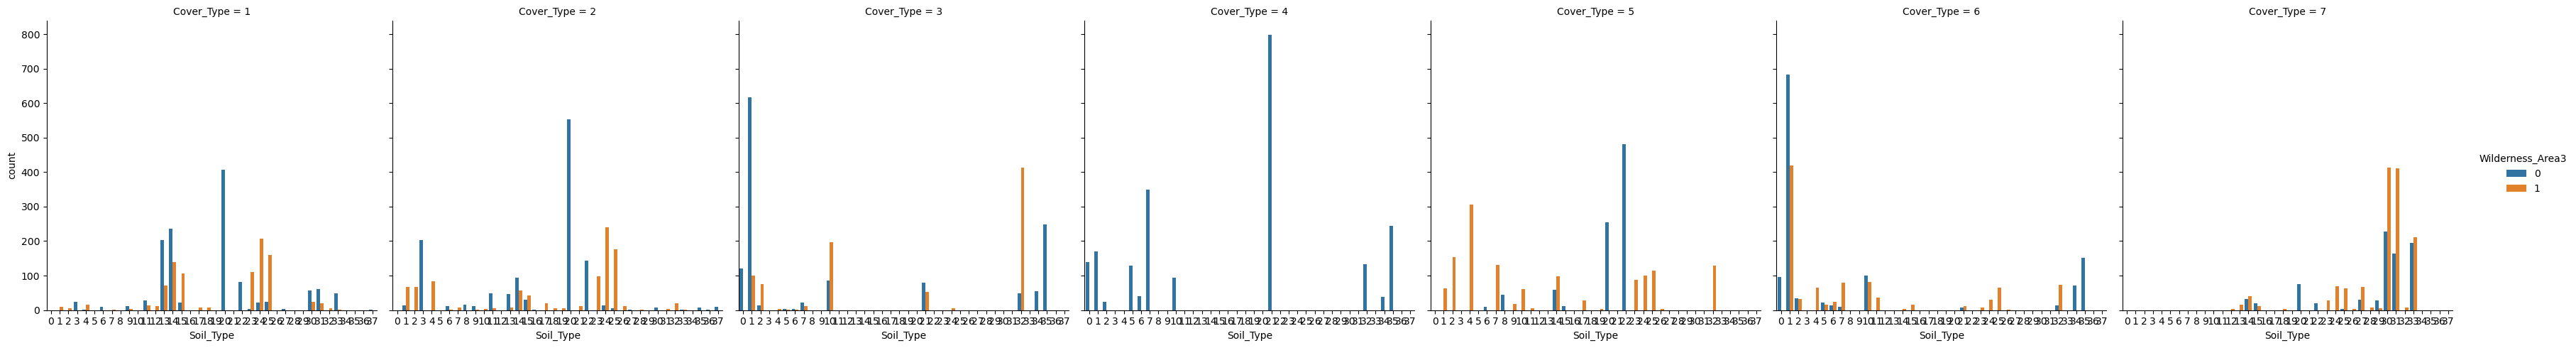

In [526]:
sns.catplot(data=df, x="Soil_Type", hue="Wilderness_Area3", col="Cover_Type", kind="count")

- Tests statistiques (cramèr's V, chi2, tests d'indépendances conditionnels)

- Chi2 (inadapté aux faibles effectifs) : 

In [527]:
contingency_table = pd.crosstab([df["Cover_Type"], df["Wilderness_Area4"]], df["Soil_Type"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi2 statistic : {chi2}")
print(f"P-value : {p}")

Chi2 statistic : 37197.443084087296
P-value : 0.0


- Cramèr's V (inadapté aux faibles effectifs): 

<Axes: >

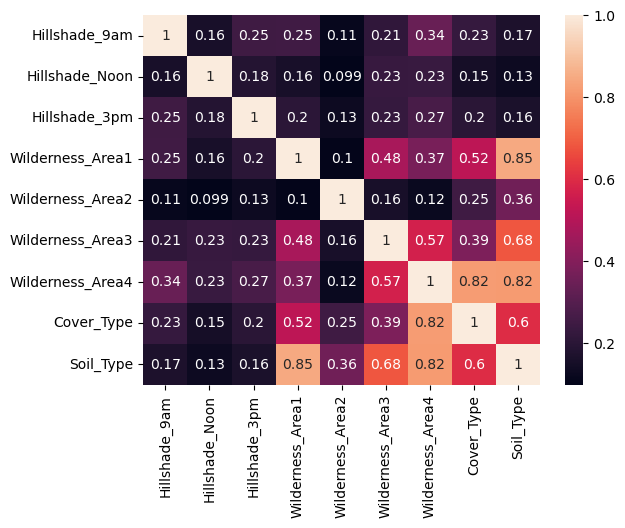

In [528]:
matrix = cramers_v_matrix(df, categorial_features)
sns.heatmap(matrix, annot=True)

- Freeman-Halton (adapté aux faibles effectifs) : 

- Cochran-Mantel-Haenszel (1 feature de controle + 2 features de 2 catégories) :

- Modélisation simple (régression/classification avec statsmodel) : 

In [ ]:
X = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1', "Wilderness_Area3", 'Wilderness_Area4', 'Soil_Type']]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

         Current function value: 1.185092
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15069
Method:                           MLE   Df Model:                           42
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.3910
Time:                        16:14:43   Log-Likelihood:                -17915.
converged:                      False   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
    Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.5965      0.936      3.843      0.000       1.762       5.431
Hillshade_9am       -0.0525      0.007     -7.2

In [535]:
X = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1', "Wilderness_Area3", 'Wilderness_Area4']]
X = sm.add_constant(X)
model = sm.MNLogit(df["Cover_Type"], X).fit()
print(model.summary())

         Current function value: 1.325517
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                        MNLogit   Df Residuals:                    15075
Method:                           MLE   Df Model:                           36
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                  0.3188
Time:                        16:17:20   Log-Likelihood:                -20038.
converged:                      False   LL-Null:                       -29416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
    Cover_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8046      0.902      0.892      0.372      -0.964       2.573
Hillshade_9am       -0.0331      0.007     -4.7

- Modélisation log-linéaire (détecte les intéractions) : 

In [541]:
model = smf.glm("Cover_Type ~ Wilderness_Area1 * Wilderness_Area3 * Wilderness_Area4 * Soil_Type", data=df, family=sm.families.Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Cover_Type   No. Observations:                15117
Model:                            GLM   Df Residuals:                    15109
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30547.
Date:                Sat, 15 Mar 2025   Deviance:                       13978.
Time:                        16:23:15   Pearson chi2:                 1.30e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1561
Covariance Type:            nonrobust                                         
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------



---


## **5. Préparation des données pour la modélisation**
- Encodage :
  - Target :
  - Features : encodage en int16 ou moins de toutes les features
- Imputation : 
  - suppression des features 'Soil_TypeX' et de 'Id'
  - suppression des outliers de 'Vertical_Distance_To_Hydrology' (>0.9)
- Transformation :
  - Feature Scaling :
    - standardisation ou normalisation de toutes les variables continues
  - Transformation Mathématique : 
    - à appliquer sur toutes les variables continues
- Feature Engineering :
  - Création de la variables 'Soil_Type', regroupant les classes '1' de tous les 'Soil_TypeX'